In [5]:
import pandas as pd
import numpy as np
import os

print("📥 Temiz veriler yükleniyor...\n")

years = [2014, 2015, 2016, 2017, 2018]
dfs_clean = {}

for year in years:
    file_path = f"../data/processed/airline_{year}_cleaned.csv"
    
    if os.path.exists(file_path):
        dfs_clean[year] = pd.read_csv(file_path)
        rows = len(dfs_clean[year])
        cols = len(dfs_clean[year].columns)
        size_mb = dfs_clean[year].memory_usage(deep=True).sum() / 1024**2
        print(f"✅ {year}: {rows:,} satır × {cols} sütun ({size_mb:.1f} MB)")
    else:
        print(f"❌ {year}: Dosya bulunamadı - {file_path}")

print(f"\n🎉 Toplam {len(dfs_clean)} yıl yüklendi!")

# Hızlı kontrol - sütunları göster
if len(dfs_clean) > 0:
    first_year = list(dfs_clean.keys())[0]
    print(f"\n📋 Sütunlar ({first_year}):")
    print(dfs_clean[first_year].columns.tolist())

📥 Temiz veriler yükleniyor...

✅ 2014: 5,819,811 satır × 30 sütun (2810.6 MB)
✅ 2015: 5,819,079 satır × 30 sütun (2809.6 MB)
✅ 2016: 5,617,658 satır × 30 sütun (2712.0 MB)
✅ 2017: 5,674,621 satır × 30 sütun (2739.8 MB)
✅ 2018: 7,213,446 satır × 30 sütun (3482.9 MB)

🎉 Toplam 5 yıl yüklendi!

📋 Sütunlar (2014):
   1. FL_DATE
   2. OP_CARRIER
   3. OP_CARRIER_FL_NUM
   4. ORIGIN
   5. DEST
   6. CRS_DEP_TIME
   7. DEP_TIME
   8. DEP_DELAY
   9. TAXI_OUT
  10. WHEELS_OFF
  11. WHEELS_ON
  12. TAXI_IN
  13. CRS_ARR_TIME
  14. ARR_TIME
  15. ARR_DELAY
  16. CANCELLED
  17. CANCELLATION_CODE
  18. DIVERTED
  19. CRS_ELAPSED_TIME
  20. ACTUAL_ELAPSED_TIME
  21. AIR_TIME
  22. DISTANCE
  23. CARRIER_DELAY
  24. WEATHER_DELAY
  25. NAS_DELAY
  26. SECURITY_DELAY
  27. LATE_AIRCRAFT_DELAY
  28. CRS_DEP_DATETIME
  29. CRS_DEP_HOUR
  30. CRS_DEP_MINUTE


In [6]:
print("✈️ HAVAYOLU KPI'LARI HESAPLANIYOR...\n")

# Boş liste - her yılın sonuçlarını buraya ekleyeceğiz
airline_kpis = []

for year in years:
    df = dfs_clean[year]
    
    # Aktif uçuşlar (iptal edilmemişler)
    df_active = df[df['CANCELLED'] == 0].copy()
    
    # Havayolu bazında grup
    kpi = df.groupby('OP_CARRIER').agg({
        'FL_DATE': 'count',  # Toplam uçuş
        'ARR_DELAY': ['mean', 'median'],  # Ortalama gecikme
        'CANCELLED': 'sum',  # İptal sayısı
        'DIVERTED': 'sum'  # Yönlendirme sayısı
    }).reset_index()
    
    # Kolon isimlerini düzelt
    kpi.columns = ['OP_CARRIER', 'Total_Flights', 'Avg_Arr_Delay', 'Median_Arr_Delay', 
                   'Total_Cancelled', 'Total_Diverted']
    
    # Gecikmiş uçuş sayısı (ARR_DELAY > 15)
    delayed = df_active[df_active['ARR_DELAY'] > 15].groupby('OP_CARRIER').size().reset_index(name='Delayed_Flights')
    kpi = kpi.merge(delayed, on='OP_CARRIER', how='left').fillna(0)
    
    # Oranları hesapla
    kpi['Delay_Rate_%'] = (kpi['Delayed_Flights'] / kpi['Total_Flights'] * 100).round(2)
    kpi['Cancellation_Rate_%'] = (kpi['Total_Cancelled'] / kpi['Total_Flights'] * 100).round(2)
    kpi['Diversion_Rate_%'] = (kpi['Total_Diverted'] / kpi['Total_Flights'] * 100).round(2)
    kpi['On_Time_Rate_%'] = (100 - kpi['Delay_Rate_%']).round(2)
    
    # Yıl ekle
    kpi['YEAR'] = year
    
    airline_kpis.append(kpi)
    print(f"✅ {year}: {len(kpi)} havayolu")

# Tüm yılları birleştir
df_airline_kpis = pd.concat(airline_kpis, ignore_index=True)

print(f"\n🎉 Havayolu KPI'ları hazır: {len(df_airline_kpis)} satır")
print("\n📊 Örnek (2018 - Top 5):")
print(df_airline_kpis[df_airline_kpis['YEAR'] == 2018].nlargest(5, 'Total_Flights')[
    ['OP_CARRIER', 'Total_Flights', 'Avg_Arr_Delay', 'Delay_Rate_%', 'On_Time_Rate_%']
])

✈️ HAVAYOLU KPI'LARI HESAPLANIYOR...

✅ 2014: 14 havayolu
✅ 2015: 14 havayolu
✅ 2016: 12 havayolu
✅ 2017: 12 havayolu
✅ 2018: 18 havayolu

🎉 Havayolu KPI'ları hazır: 70 satır

📊 Örnek (2018 - Top 5):
   OP_CARRIER  Total_Flights  Avg_Arr_Delay  Delay_Rate_%  On_Time_Rate_%
67         WN        1352552       4.519644         18.46           81.54
56         DL         949283      -0.289825         13.18           86.82
53         AA         916818       5.432065         19.02           80.98
64         OO         774137       7.044141         17.89           82.11
65         UA         621565       5.764875         18.61           81.39


In [7]:
print("🛫 HAVALİMANI (ORIGIN) KPI'LARI HESAPLANIYOR...\n")

airport_origin_kpis = []

for year in years:
    df = dfs_clean[year]
    df_active = df[df['CANCELLED'] == 0].copy()
    
    # Origin bazında grup
    kpi = df.groupby('ORIGIN').agg({
        'FL_DATE': 'count',  # Toplam uçuş
        'DEP_DELAY': ['mean', 'median'],  # Kalkış gecikmesi
        'ARR_DELAY': 'mean',  # Varış gecikmesi (rota performansı için)
        'CANCELLED': 'sum',
        'TAXI_OUT': 'mean'  # Ortalama taxi-out
    }).reset_index()
    
    kpi.columns = ['ORIGIN', 'Total_Flights', 'Avg_Dep_Delay', 'Median_Dep_Delay', 
                   'Avg_Arr_Delay', 'Total_Cancelled', 'Avg_Taxi_Out']
    
    # Gecikmiş kalkış sayısı
    delayed = df_active[df_active['DEP_DELAY'] > 15].groupby('ORIGIN').size().reset_index(name='Delayed_Departures')
    kpi = kpi.merge(delayed, on='ORIGIN', how='left').fillna(0)
    
    # Oranlar
    kpi['Departure_Delay_Rate_%'] = (kpi['Delayed_Departures'] / kpi['Total_Flights'] * 100).round(2)
    kpi['Cancellation_Rate_%'] = (kpi['Total_Cancelled'] / kpi['Total_Flights'] * 100).round(2)
    
    # Yıl ve tip ekle
    kpi['YEAR'] = year
    kpi['Airport_Type'] = 'ORIGIN'
    
    airport_origin_kpis.append(kpi)
    print(f"✅ {year}: {len(kpi)} havalimanı")

df_airport_origin_kpis = pd.concat(airport_origin_kpis, ignore_index=True)

print(f"\n🎉 Origin KPI'ları hazır: {len(df_airport_origin_kpis)} satır")
print("\n📊 Örnek (2018 - En yoğun 5):")
print(df_airport_origin_kpis[df_airport_origin_kpis['YEAR'] == 2018].nlargest(5, 'Total_Flights')[
    ['ORIGIN', 'Total_Flights', 'Avg_Dep_Delay', 'Departure_Delay_Rate_%', 'Avg_Taxi_Out']
])


🛫 HAVALİMANI (ORIGIN) KPI'LARI HESAPLANIYOR...

✅ 2014: 325 havalimanı
✅ 2015: 322 havalimanı
✅ 2016: 313 havalimanı
✅ 2017: 320 havalimanı
✅ 2018: 358 havalimanı

🎉 Origin KPI'ları hazır: 1638 satır

📊 Örnek (2018 - En yoğun 5):
     ORIGIN  Total_Flights  Avg_Dep_Delay  Departure_Delay_Rate_%  \
1301    ATL         390046       9.601255                   17.18   
1527    ORD         332953      12.354665                   19.75   
1372    DFW         279298      12.101526                   19.70   
1371    DEN         235989      10.375177                   18.47   
1351    CLT         233317      10.745946                   18.21   

      Avg_Taxi_Out  
1301     16.952014  
1527     22.471003  
1372     18.678155  
1371     17.126599  
1351     20.219263  


In [8]:
print("\n🛬 HAVALİMANI (DESTINATION) KPI'LARI HESAPLANIYOR...\n")

airport_dest_kpis = []

for year in years:
    df = dfs_clean[year]
    df_active = df[df['CANCELLED'] == 0].copy()
    
    # Destination bazında grup
    kpi = df.groupby('DEST').agg({
        'FL_DATE': 'count',
        'ARR_DELAY': ['mean', 'median'],
        'CANCELLED': 'sum',
        'TAXI_IN': 'mean'
    }).reset_index()
    
    kpi.columns = ['DEST', 'Total_Flights', 'Avg_Arr_Delay', 'Median_Arr_Delay', 
                   'Total_Cancelled', 'Avg_Taxi_In']
    
    # Gecikmiş varış
    delayed = df_active[df_active['ARR_DELAY'] > 15].groupby('DEST').size().reset_index(name='Delayed_Arrivals')
    kpi = kpi.merge(delayed, on='DEST', how='left').fillna(0)
    
    # Oranlar
    kpi['Arrival_Delay_Rate_%'] = (kpi['Delayed_Arrivals'] / kpi['Total_Flights'] * 100).round(2)
    kpi['Cancellation_Rate_%'] = (kpi['Total_Cancelled'] / kpi['Total_Flights'] * 100).round(2)
    
    kpi['YEAR'] = year
    kpi['Airport_Type'] = 'DESTINATION'
    
    airport_dest_kpis.append(kpi)
    print(f"✅ {year}: {len(kpi)} havalimanı")

df_airport_dest_kpis = pd.concat(airport_dest_kpis, ignore_index=True)

print(f"\n🎉 Destination KPI'ları hazır: {len(df_airport_dest_kpis)} satır")


🛬 HAVALİMANI (DESTINATION) KPI'LARI HESAPLANIYOR...

✅ 2014: 324 havalimanı
✅ 2015: 322 havalimanı
✅ 2016: 310 havalimanı
✅ 2017: 320 havalimanı
✅ 2018: 358 havalimanı

🎉 Destination KPI'ları hazır: 1634 satır


In [12]:
print("🛫➡️🛬 ROTA KPI'LARI HESAPLANIYOR...\n")

route_kpis = []

for year in years:
    df = dfs_clean[year]
    df_active = df[df['CANCELLED'] == 0].copy()
    
    # Rota oluştur
    df['ROUTE'] = df['ORIGIN'] + '-' + df['DEST']
    df_active['ROUTE'] = df_active['ORIGIN'] + '-' + df_active['DEST']
    
    # Rota bazında grup
    kpi = df.groupby('ROUTE').agg({
        'FL_DATE': 'count',
        'ARR_DELAY': 'mean',
        'DISTANCE': 'first',  # Mesafe sabit
        'CANCELLED': 'sum'
    }).reset_index()
    
    kpi.columns = ['ROUTE', 'Total_Flights', 'Avg_Arr_Delay', 'Distance', 'Total_Cancelled']
    
    # Gecikmiş uçuşlar
    delayed = df_active[df_active['ARR_DELAY'] > 15].groupby('ROUTE').size().reset_index(name='Delayed_Flights')
    kpi = kpi.merge(delayed, on='ROUTE', how='left').fillna(0)
    
    # Oranlar
    kpi['Delay_Rate_%'] = (kpi['Delayed_Flights'] / kpi['Total_Flights'] * 100).round(2)
    kpi['Cancellation_Rate_%'] = (kpi['Total_Cancelled'] / kpi['Total_Flights'] * 100).round(2)
    
    # Origin ve Dest'i ayır (Power BI için)
    kpi[['ORIGIN', 'DEST']] = kpi['ROUTE'].str.split('-', expand=True)
    
    kpi['YEAR'] = year
    
    # Sadece 50+ uçuşu olan rotaları al (çok nadir rotaları filtrele)
    kpi = kpi[kpi['Total_Flights'] >= 100].copy()
    
    route_kpis.append(kpi)
    print(f"✅ {year}: {len(kpi)} rota (100+ uçuş)")

df_route_kpis = pd.concat(route_kpis, ignore_index=True)

print(f"\n🎉 Rota KPI'ları hazır: {len(df_route_kpis)} satır")
print("\n📊 Örnek (2018 - En yoğun 5 rota):")
print(df_route_kpis[df_route_kpis['YEAR'] == 2018].nlargest(5, 'Total_Flights')[
    ['ROUTE', 'Total_Flights', 'Distance', 'Avg_Arr_Delay', 'Delay_Rate_%']
])


🛫➡️🛬 ROTA KPI'LARI HESAPLANIYOR...

✅ 2014: 4106 rota (100+ uçuş)
✅ 2015: 4098 rota (100+ uçuş)
✅ 2016: 4005 rota (100+ uçuş)
✅ 2017: 4090 rota (100+ uçuş)
✅ 2018: 5236 rota (100+ uçuş)

🎉 Rota KPI'ları hazır: 21535 satır

📊 Örnek (2018 - En yoğun 5 rota):
         ROUTE  Total_Flights  Distance  Avg_Arr_Delay  Delay_Rate_%
19971  ORD-LGA          15281     733.0      16.592884         27.77
19109  LGA-ORD          15279     733.0      11.329080         24.18
20989  SFO-LAX          15158     337.0       8.116503         23.90
19013  LAX-SFO          15143     337.0       7.812330         23.86
18979  LAX-JFK          12791    2475.0       2.137049         18.69


In [10]:
print("\n⚙️ OPERASYONEL KPI'LARI HESAPLANIYOR...\n")

operational_kpis = []

for year in years:
    df = dfs_clean[year]
    df_active = df[df['CANCELLED'] == 0].copy()
    
    # Genel operasyonel metrikler
    kpi = {
        'YEAR': year,
        'Total_Flights': len(df),
        'Active_Flights': len(df_active),
        'Cancelled_Flights': int(df['CANCELLED'].sum()),
        'Diverted_Flights': int(df['DIVERTED'].sum()),
        
        # Taxi süreleri
        'Avg_Taxi_Out_Min': df_active['TAXI_OUT'].mean(),
        'Avg_Taxi_In_Min': df_active['TAXI_IN'].mean(),
        'Total_Taxi_Time_Min': (df_active['TAXI_OUT'] + df_active['TAXI_IN']).mean(),
        
        # Gecikme metrikleri
        'Avg_Dep_Delay_Min': df_active['DEP_DELAY'].mean(),
        'Avg_Arr_Delay_Min': df_active['ARR_DELAY'].mean(),
        'Median_Dep_Delay_Min': df_active['DEP_DELAY'].median(),
        'Median_Arr_Delay_Min': df_active['ARR_DELAY'].median(),
        
        # Uçuş süresi farkı
        'Avg_Scheduled_Time_Min': df_active['CRS_ELAPSED_TIME'].mean(),
        'Avg_Actual_Time_Min': df_active['ACTUAL_ELAPSED_TIME'].mean(),
        'Avg_Time_Difference_Min': (df_active['ACTUAL_ELAPSED_TIME'] - df_active['CRS_ELAPSED_TIME']).mean(),
        
        # Mesafe metrikleri
        'Avg_Distance_Miles': df_active['DISTANCE'].mean(),
        'Total_Distance_Miles': df_active['DISTANCE'].sum(),
        
        # On-time performance
        'Delayed_Flights': int((df_active['ARR_DELAY'] > 15).sum()),
        'On_Time_Flights': int((df_active['ARR_DELAY'] <= 15).sum()),
    }
    
    # Oranları hesapla
    kpi['Cancellation_Rate_%'] = (kpi['Cancelled_Flights'] / kpi['Total_Flights'] * 100)
    kpi['Diversion_Rate_%'] = (kpi['Diverted_Flights'] / kpi['Total_Flights'] * 100)
    kpi['Delay_Rate_%'] = (kpi['Delayed_Flights'] / kpi['Active_Flights'] * 100)
    kpi['On_Time_Rate_%'] = (kpi['On_Time_Flights'] / kpi['Active_Flights'] * 100)
    
    # Mesafe başına gecikme (dk/1000 mil)
    total_delay = df_active[df_active['ARR_DELAY'] > 0]['ARR_DELAY'].sum()
    kpi['Delay_Per_1000Miles'] = (total_delay / (kpi['Total_Distance_Miles'] / 1000))
    
    operational_kpis.append(kpi)
    print(f"✅ {year}: Operasyonel metrikler hesaplandı")

df_operational_kpis = pd.DataFrame(operational_kpis)

# Yuvarlama
numeric_cols = df_operational_kpis.select_dtypes(include=['float64']).columns
df_operational_kpis[numeric_cols] = df_operational_kpis[numeric_cols].round(2)

print(f"\n🎉 Operasyonel KPI'lar hazır: {len(df_operational_kpis)} satır")
print("\n📊 Yıllık karşılaştırma:")
print(df_operational_kpis[['YEAR', 'Total_Flights', 'On_Time_Rate_%', 
                           'Avg_Taxi_Out_Min', 'Avg_Arr_Delay_Min']])


⚙️ OPERASYONEL KPI'LARI HESAPLANIYOR...

✅ 2014: Operasyonel metrikler hesaplandı
✅ 2015: Operasyonel metrikler hesaplandı
✅ 2016: Operasyonel metrikler hesaplandı
✅ 2017: Operasyonel metrikler hesaplandı
✅ 2018: Operasyonel metrikler hesaplandı

🎉 Operasyonel KPI'lar hazır: 5 satır

📊 Yıllık karşılaştırma:
   YEAR  Total_Flights  On_Time_Rate_%  Avg_Taxi_Out_Min  Avg_Arr_Delay_Min
0  2014        5819811           78.78             15.67               7.33
1  2015        5819079           81.87             16.07               4.41
2  2016        5617658           83.03             16.19               3.52
3  2017        5674621           82.03             16.78               4.33
4  2018        7213446           81.32             17.41               5.05


In [15]:
# 6.2 Saatlik KPI'lar - DÜZELTİLMİŞ
print("\n🕐 Saatlik KPI'lar...")
hourly_kpis = []

for year in years:
    df = dfs_clean[year].copy()
    df_active = df[df['CANCELLED'] == 0].copy()
    
    # CRS_DEP_HOUR zaten var
    kpi = df.groupby('CRS_DEP_HOUR').agg({
        'FL_DATE': 'count',
        'ARR_DELAY': 'mean',
        'DEP_DELAY': 'mean',
        'CANCELLED': 'sum'
    }).reset_index()
    
    kpi.columns = ['CRS_DEP_HOUR', 'Total_Flights', 'Avg_Arr_Delay', 'Avg_Dep_Delay', 'Total_Cancelled']
    
    delayed = df_active[df_active['ARR_DELAY'] > 15].groupby('CRS_DEP_HOUR').size().reset_index(name='Delayed_Flights')
    kpi = kpi.merge(delayed, on='CRS_DEP_HOUR', how='left').fillna(0)
    
    kpi['Delay_Rate_%'] = (kpi['Delayed_Flights'] / kpi['Total_Flights'] * 100).round(2)
    kpi['YEAR'] = year
    
    # Sütun ismini değiştir (Power BI için)
    kpi.rename(columns={'CRS_DEP_HOUR': 'HOUR'}, inplace=True)
    
    hourly_kpis.append(kpi)
    print(f"  ✅ {year}")

df_hourly_kpis = pd.concat(hourly_kpis, ignore_index=True)
print(f"✅ Saatlik KPI'lar: {len(df_hourly_kpis)} satır")


🕐 Saatlik KPI'lar...
  ✅ 2014
  ✅ 2015
  ✅ 2016
  ✅ 2017
  ✅ 2018
✅ Saatlik KPI'lar: 120 satır


In [17]:
print("📅 ZAMAN BAZLI KPI'LARI HESAPLANIYOR...\n")

# 6.1 Aylık KPI'lar
print("📆 Aylık KPI'lar...")
monthly_kpis = []

for year in years:
    df = dfs_clean[year].copy()
    
    # FL_DATE'i datetime'a çevir
    if df['FL_DATE'].dtype == 'object':
        df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    
    df['MONTH'] = df['FL_DATE'].dt.month
    df_active = df[df['CANCELLED'] == 0].copy()
    
    # Aylık grup
    kpi = df.groupby('MONTH').agg({
        'FL_DATE': 'count',
        'ARR_DELAY': 'mean',
        'DEP_DELAY': 'mean',
        'CANCELLED': 'sum',
        'DISTANCE': 'sum'
    }).reset_index()
    
    kpi.columns = ['MONTH', 'Total_Flights', 'Avg_Arr_Delay', 'Avg_Dep_Delay', 
                   'Total_Cancelled', 'Total_Distance']
    
    # Gecikmiş uçuşlar
    delayed = df_active[df_active['ARR_DELAY'] > 15].groupby('MONTH').size().reset_index(name='Delayed_Flights')
    kpi = kpi.merge(delayed, on='MONTH', how='left').fillna(0)
    
    kpi['Delay_Rate_%'] = (kpi['Delayed_Flights'] / kpi['Total_Flights'] * 100).round(2)
    kpi['Cancellation_Rate_%'] = (kpi['Total_Cancelled'] / kpi['Total_Flights'] * 100).round(2)
    kpi['YEAR'] = year
    
    monthly_kpis.append(kpi)
    print(f"  ✅ {year}")

df_monthly_kpis = pd.concat(monthly_kpis, ignore_index=True)
print(f"✅ Aylık KPI'lar: {len(df_monthly_kpis)} satır")


# 6.2 Saatlik KPI'lar
print("\n🕐 Saatlik KPI'lar...")
hourly_kpis = []

for year in years:
    df = dfs_clean[year].copy()
    df_active = df[df['CANCELLED'] == 0].copy()
    
    # CRS_DEP_HOUR ile grupla
    kpi = df.groupby('CRS_DEP_HOUR').agg({
        'FL_DATE': 'count',
        'ARR_DELAY': 'mean',
        'DEP_DELAY': 'mean',
        'CANCELLED': 'sum'
    }).reset_index()
    
    kpi.columns = ['CRS_DEP_HOUR', 'Total_Flights', 'Avg_Arr_Delay', 'Avg_Dep_Delay', 'Total_Cancelled']
    
    # Gecikmiş uçuşlar
    delayed = df_active[df_active['ARR_DELAY'] > 15].groupby('CRS_DEP_HOUR').size().reset_index(name='Delayed_Flights')
    kpi = kpi.merge(delayed, on='CRS_DEP_HOUR', how='left').fillna(0)
    
    kpi['Delay_Rate_%'] = (kpi['Delayed_Flights'] / kpi['Total_Flights'] * 100).round(2)
    kpi['YEAR'] = year
    
    # Sütun adını değiştir
    kpi.rename(columns={'CRS_DEP_HOUR': 'HOUR'}, inplace=True)
    
    hourly_kpis.append(kpi)
    print(f"  ✅ {year}")

df_hourly_kpis = pd.concat(hourly_kpis, ignore_index=True)
print(f"✅ Saatlik KPI'lar: {len(df_hourly_kpis)} satır")


# 6.3 Haftanın Günü KPI'ları
print("\n📆 Haftanın Günü KPI'lar...")
dow_kpis = []

for year in years:
    df = dfs_clean[year].copy()
    
    # FL_DATE'i datetime'a çevir
    if df['FL_DATE'].dtype == 'object':
        df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    
    df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek + 1  # 1=Pazartesi, 7=Pazar
    df_active = df[df['CANCELLED'] == 0].copy()
    
    kpi = df.groupby('DAY_OF_WEEK').agg({
        'FL_DATE': 'count',
        'ARR_DELAY': 'mean',
        'DEP_DELAY': 'mean',
        'CANCELLED': 'sum'
    }).reset_index()
    
    kpi.columns = ['DAY_OF_WEEK', 'Total_Flights', 'Avg_Arr_Delay', 'Avg_Dep_Delay', 'Total_Cancelled']
    
    # Gecikmiş uçuşlar
    delayed = df_active[df_active['ARR_DELAY'] > 15].groupby('DAY_OF_WEEK').size().reset_index(name='Delayed_Flights')
    kpi = kpi.merge(delayed, on='DAY_OF_WEEK', how='left').fillna(0)
    
    kpi['Delay_Rate_%'] = (kpi['Delayed_Flights'] / kpi['Total_Flights'] * 100).round(2)
    kpi['YEAR'] = year
    
    dow_kpis.append(kpi)
    print(f"  ✅ {year}")

df_dow_kpis = pd.concat(dow_kpis, ignore_index=True)
print(f"✅ Günlük KPI'lar: {len(df_dow_kpis)} satır")


# 6.4 Sezon KPI'ları
print("\n🌸☀️🍂❄️ Sezon KPI'lar...")
season_kpis = []

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

for year in years:
    df = dfs_clean[year].copy()
    
    if df['FL_DATE'].dtype == 'object':
        df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    
    df['MONTH'] = df['FL_DATE'].dt.month
    df['SEASON'] = df['MONTH'].apply(get_season)
    df_active = df[df['CANCELLED'] == 0].copy()
    
    kpi = df.groupby('SEASON').agg({
        'FL_DATE': 'count',
        'ARR_DELAY': 'mean',
        'DEP_DELAY': 'mean',
        'CANCELLED': 'sum'
    }).reset_index()
    
    kpi.columns = ['SEASON', 'Total_Flights', 'Avg_Arr_Delay', 'Avg_Dep_Delay', 'Total_Cancelled']
    
    # Gecikmiş uçuşlar
    delayed = df_active[df_active['ARR_DELAY'] > 15].groupby('SEASON').size().reset_index(name='Delayed_Flights')
    kpi = kpi.merge(delayed, on='SEASON', how='left').fillna(0)
    
    kpi['Delay_Rate_%'] = (kpi['Delayed_Flights'] / kpi['Total_Flights'] * 100).round(2)
    kpi['Cancellation_Rate_%'] = (kpi['Total_Cancelled'] / kpi['Total_Flights'] * 100).round(2)
    kpi['YEAR'] = year
    
    season_kpis.append(kpi)
    print(f"  ✅ {year}")

df_season_kpis = pd.concat(season_kpis, ignore_index=True)
print(f"✅ Sezon KPI'lar: {len(df_season_kpis)} satır")

print("\n🎉 TÜM ZAMAN BAZLI KPI'LAR HAZIR!")

📅 ZAMAN BAZLI KPI'LARI HESAPLANIYOR...

📆 Aylık KPI'lar...
  ✅ 2014
  ✅ 2015
  ✅ 2016
  ✅ 2017
  ✅ 2018
✅ Aylık KPI'lar: 60 satır

🕐 Saatlik KPI'lar...
  ✅ 2014
  ✅ 2015
  ✅ 2016
  ✅ 2017
  ✅ 2018
✅ Saatlik KPI'lar: 120 satır

📆 Haftanın Günü KPI'lar...
  ✅ 2014
  ✅ 2015
  ✅ 2016
  ✅ 2017
  ✅ 2018
✅ Günlük KPI'lar: 35 satır

🌸☀️🍂❄️ Sezon KPI'lar...
  ✅ 2014
  ✅ 2015
  ✅ 2016
  ✅ 2017
  ✅ 2018
✅ Sezon KPI'lar: 20 satır

🎉 TÜM ZAMAN BAZLI KPI'LAR HAZIR!


In [18]:
# 📊 TÜM KPI'LARI KONTROL ET

print("=" * 70)
print("📊 YUSUF KPI'LARI - ÖZET")
print("=" * 70)

kpi_datasets = {
    '1. Havayolu KPI': df_airline_kpis,
    '2. Havalimanı (Origin) KPI': df_airport_origin_kpis,
    '3. Havalimanı (Destination) KPI': df_airport_dest_kpis,
    '4. Rota KPI': df_route_kpis,
    '5. Operasyonel KPI': df_operational_kpis,
    '6. Aylık KPI': df_monthly_kpis,
    '7. Saatlik KPI': df_hourly_kpis,
    '8. Günlük KPI': df_dow_kpis,
    '9. Sezon KPI': df_season_kpis
}

for name, df in kpi_datasets.items():
    size_kb = df.memory_usage(deep=True).sum() / 1024
    print(f"\n{name}:")
    print(f"  • Satır: {len(df):,}")
    print(f"  • Sütun: {len(df.columns)}")
    print(f"  • Boyut: {size_kb:.1f} KB")

total_size = sum(df.memory_usage(deep=True).sum() for df in kpi_datasets.values()) / 1024
print(f"\n{'=' * 70}")
print(f"📦 TOPLAM BOYUT: {total_size:.1f} KB (~{total_size/1024:.2f} MB)")
print(f"🎉 5 GB veri → {total_size/1024:.1f} MB özetlenmiş KPI'lara dönüştü!")
print(f"{'=' * 70}")

📊 YUSUF KPI'LARI - ÖZET

1. Havayolu KPI:
  • Satır: 70
  • Sütun: 12
  • Boyut: 9.6 KB

2. Havalimanı (Origin) KPI:
  • Satır: 1,638
  • Sütun: 12
  • Boyut: 299.3 KB

3. Havalimanı (Destination) KPI:
  • Satır: 1,634
  • Sütun: 11
  • Boyut: 293.7 KB

4. Rota KPI:
  • Satır: 21,535
  • Sütun: 11
  • Boyut: 4710.9 KB

5. Operasyonel KPI:
  • Satır: 5
  • Sütun: 24
  • Boyut: 1.1 KB

6. Aylık KPI:
  • Satır: 60
  • Sütun: 10
  • Boyut: 4.6 KB

7. Saatlik KPI:
  • Satır: 120
  • Sütun: 8
  • Boyut: 7.6 KB

8. Günlük KPI:
  • Satır: 35
  • Sütun: 8
  • Boyut: 2.2 KB

9. Sezon KPI:
  • Satır: 20
  • Sütun: 9
  • Boyut: 2.4 KB

📦 TOPLAM BOYUT: 5331.4 KB (~5.21 MB)
🎉 5 GB veri → 5.2 MB özetlenmiş KPI'lara dönüştü!


In [19]:
# 📊 Örnek veriler - Her KPI'dan 3 satır
print("\n\n📋 ÖRNEK VERİLER:\n")

for name, df in kpi_datasets.items():
    print(f"\n{name}:")
    print(df.head(3))



📋 ÖRNEK VERİLER:


1. Havayolu KPI:
  OP_CARRIER  Total_Flights  Avg_Arr_Delay  Median_Arr_Delay  Total_Cancelled  \
0         AA         537697       8.300543              -2.0           8457.0   
1         AS         160257      -0.300682              -4.0            759.0   
2         B6         249693       6.912538              -4.0           6076.0   

   Total_Diverted  Delayed_Flights  Delay_Rate_%  Cancellation_Rate_%  \
0          1957.0           115393         21.46                 1.57   
1           443.0            19777         12.34                 0.47   
2           690.0            52641         21.08                 2.43   

   Diversion_Rate_%  On_Time_Rate_%  YEAR  
0              0.36           78.54  2014  
1              0.28           87.66  2014  
2              0.28           78.92  2014  

2. Havalimanı (Origin) KPI:
  ORIGIN  Total_Flights  Avg_Dep_Delay  Median_Dep_Delay  Avg_Arr_Delay  \
0    ABE           1638       9.158730              -4.0       6

In [20]:
print("💾 KPI'LAR CSV OLARAK KAYDEDİLİYOR...\n")

# Çıktı klasörü
output_dir = "../data/kpis"

# Klasör yoksa oluştur
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"✅ {output_dir} klasörü oluşturuldu\n")

# Her KPI'yı ayrı CSV olarak kaydet
kpi_files = {
    'yusuf_kpi_airline.csv': df_airline_kpis,
    'yusuf_kpi_airport_origin.csv': df_airport_origin_kpis,
    'yusuf_kpi_airport_destination.csv': df_airport_dest_kpis,
    'yusuf_kpi_route.csv': df_route_kpis,
    'yusuf_kpi_operational.csv': df_operational_kpis,
    'yusuf_kpi_monthly.csv': df_monthly_kpis,
    'yusuf_kpi_hourly.csv': df_hourly_kpis,
    'yusuf_kpi_daily.csv': df_dow_kpis,
    'yusuf_kpi_seasonal.csv': df_season_kpis
}

for filename, dataframe in kpi_files.items():
    filepath = os.path.join(output_dir, filename)
    dataframe.to_csv(filepath, index=False, encoding='utf-8')
    
    file_size = os.path.getsize(filepath) / 1024
    print(f"✅ {filename:40s} → {file_size:8.1f} KB")

print(f"\n🎉 9 KPI dosyası kaydedildi: {output_dir}/")

💾 KPI'LAR CSV OLARAK KAYDEDİLİYOR...

✅ ../data/kpis klasörü oluşturuldu

✅ yusuf_kpi_airline.csv                    →      5.7 KB
✅ yusuf_kpi_airport_origin.csv             →    166.4 KB
✅ yusuf_kpi_airport_destination.csv        →    144.4 KB
✅ yusuf_kpi_route.csv                      →   1514.7 KB
✅ yusuf_kpi_operational.csv                →      1.2 KB
✅ yusuf_kpi_monthly.csv                    →      5.3 KB
✅ yusuf_kpi_hourly.csv                     →      8.3 KB
✅ yusuf_kpi_daily.csv                      →      2.6 KB
✅ yusuf_kpi_seasonal.csv                   →      1.7 KB

🎉 9 KPI dosyası kaydedildi: ../data/kpis/


In [21]:
# Kaydedilen dosyaları kontrol et
print("\n\n📂 KPI KLASÖRÜ İÇERİĞİ:\n")

total_size = 0
for file in sorted(os.listdir(output_dir)):
    if file.endswith('.csv'):
        filepath = os.path.join(output_dir, file)
        size_kb = os.path.getsize(filepath) / 1024
        total_size += size_kb
        
        # İlk satırı oku
        preview = pd.read_csv(filepath, nrows=1)
        print(f"📄 {file}")
        print(f"   Boyut: {size_kb:.1f} KB | Satır: {len(pd.read_csv(filepath)):,} | Sütun: {len(preview.columns)}")

print(f"\n💾 Toplam: {total_size:.1f} KB ({total_size/1024:.2f} MB)")



📂 KPI KLASÖRÜ İÇERİĞİ:

📄 yusuf_kpi_airline.csv
   Boyut: 5.7 KB | Satır: 70 | Sütun: 12
📄 yusuf_kpi_airport_destination.csv
   Boyut: 144.4 KB | Satır: 1,634 | Sütun: 11
📄 yusuf_kpi_airport_origin.csv
   Boyut: 166.4 KB | Satır: 1,638 | Sütun: 12
📄 yusuf_kpi_daily.csv
   Boyut: 2.6 KB | Satır: 35 | Sütun: 8
📄 yusuf_kpi_hourly.csv
   Boyut: 8.3 KB | Satır: 120 | Sütun: 8
📄 yusuf_kpi_monthly.csv
   Boyut: 5.3 KB | Satır: 60 | Sütun: 10
📄 yusuf_kpi_operational.csv
   Boyut: 1.2 KB | Satır: 5 | Sütun: 24
📄 yusuf_kpi_route.csv
   Boyut: 1514.7 KB | Satır: 21,535 | Sütun: 11
📄 yusuf_kpi_seasonal.csv
   Boyut: 1.7 KB | Satır: 20 | Sütun: 9

💾 Toplam: 1850.3 KB (1.81 MB)


In [24]:
print("🔗 1. HAVAYOLU-HAVALİMANI KOMBİNASYON KPI'LARI\n")

carrier_airport_kpis = []

for year in years:
    df = dfs_clean[year].copy()
    df_active = df[df['CANCELLED'] == 0].copy()
    
    # Havayolu + Origin kombinasyonu
    kpi_origin = df.groupby(['OP_CARRIER', 'ORIGIN']).agg({
        'FL_DATE': 'count',
        'DEP_DELAY': 'mean',
        'ARR_DELAY': 'mean',
        'CANCELLED': 'sum'
    }).reset_index()
    
    kpi_origin.columns = ['OP_CARRIER', 'AIRPORT', 'Total_Flights', 
                          'Avg_Dep_Delay', 'Avg_Arr_Delay', 'Total_Cancelled']
    
    # Gecikmiş uçuşlar
    delayed = df_active[df_active['ARR_DELAY'] > 15].groupby(['OP_CARRIER', 'ORIGIN']).size().reset_index(name='Delayed_Flights')
    delayed.columns = ['OP_CARRIER', 'AIRPORT', 'Delayed_Flights']
    kpi_origin = kpi_origin.merge(delayed, on=['OP_CARRIER', 'AIRPORT'], how='left').fillna(0)
    
    # Oranlar
    kpi_origin['On_Time_Rate_%'] = ((kpi_origin['Total_Flights'] - kpi_origin['Delayed_Flights']) / kpi_origin['Total_Flights'] * 100).round(2)
    kpi_origin['Cancellation_Rate_%'] = (kpi_origin['Total_Cancelled'] / kpi_origin['Total_Flights'] * 100).round(2)
    
    kpi_origin['YEAR'] = year
    kpi_origin['Airport_Type'] = 'ORIGIN'
    
    # Minimum 50 uçuş filtresi (çok nadir kombinasyonları çıkar)
    kpi_origin = kpi_origin[kpi_origin['Total_Flights'] >= 50].copy()
    
    carrier_airport_kpis.append(kpi_origin)
    print(f"  ✅ {year}: {len(kpi_origin)} kombinasyon")

df_carrier_airport_kpis = pd.concat(carrier_airport_kpis, ignore_index=True)

print(f"\n✅ Havayolu-Havalimanı KPI'ları: {len(df_carrier_airport_kpis)} satır")
print(f"   Power BI'da: Havayolu seç → Hangi havalimanında en iyi?")
print("\n📊 Örnek (2018 - Southwest'in en iyi/kötü havalimanları):")
sw_2018 = df_carrier_airport_kpis[(df_carrier_airport_kpis['YEAR'] == 2018) & 
                                   (df_carrier_airport_kpis['OP_CARRIER'] == 'WN')].nlargest(3, 'On_Time_Rate_%')
print(sw_2018[['OP_CARRIER', 'AIRPORT', 'Total_Flights', 'On_Time_Rate_%', 'Avg_Arr_Delay']])

🔗 1. HAVAYOLU-HAVALİMANI KOMBİNASYON KPI'LARI

  ✅ 2014: 1242 kombinasyon
  ✅ 2015: 1235 kombinasyon
  ✅ 2016: 1056 kombinasyon
  ✅ 2017: 1117 kombinasyon
  ✅ 2018: 1843 kombinasyon

✅ Havayolu-Havalimanı KPI'ları: 6493 satır
   Power BI'da: Havayolu seç → Hangi havalimanında en iyi?

📊 Örnek (2018 - Southwest'in en iyi/kötü havalimanları):
     OP_CARRIER AIRPORT  Total_Flights  On_Time_Rate_%  Avg_Arr_Delay
6250         WN     LGB           2866           91.56      -2.935687
6236         WN     GEG           3951           89.22      -0.990861
6242         WN     ICT           1415           89.05      -0.704545


In [25]:
print("\n\n📏 2. MESAFE-GECİKME İLİŞKİSİ KPI'LARI\n")

distance_kpis = []

# Mesafe kategorileri tanımla
def get_distance_category(distance):
    if distance <= 500:
        return 'Short (<500 mi)'
    elif distance <= 1000:
        return 'Medium (500-1000 mi)'
    elif distance <= 2000:
        return 'Long (1000-2000 mi)'
    else:
        return 'Very Long (>2000 mi)'

for year in years:
    df = dfs_clean[year].copy()
    df_active = df[df['CANCELLED'] == 0].copy()
    
    df['DISTANCE_CATEGORY'] = df['DISTANCE'].apply(get_distance_category)
    df_active['DISTANCE_CATEGORY'] = df_active['DISTANCE'].apply(get_distance_category)
    
    kpi = df.groupby('DISTANCE_CATEGORY').agg({
        'FL_DATE': 'count',
        'DEP_DELAY': 'mean',
        'ARR_DELAY': 'mean',
        'DISTANCE': 'mean',
        'CANCELLED': 'sum',
        'AIR_TIME': 'mean'
    }).reset_index()
    
    kpi.columns = ['Distance_Category', 'Total_Flights', 'Avg_Dep_Delay', 
                   'Avg_Arr_Delay', 'Avg_Distance', 'Total_Cancelled', 'Avg_Air_Time']
    
    # Gecikmiş uçuşlar
    delayed = df_active[df_active['ARR_DELAY'] > 15].groupby('DISTANCE_CATEGORY').size().reset_index(name='Delayed_Flights')
    kpi = kpi.merge(delayed, left_on='Distance_Category', right_on='DISTANCE_CATEGORY', how='left').fillna(0)
    kpi.drop('DISTANCE_CATEGORY', axis=1, inplace=True)
    
    kpi['Delay_Rate_%'] = (kpi['Delayed_Flights'] / kpi['Total_Flights'] * 100).round(2)
    kpi['YEAR'] = year
    
    distance_kpis.append(kpi)
    print(f"  ✅ {year}")

df_distance_kpis = pd.concat(distance_kpis, ignore_index=True)

print(f"\n✅ Mesafe-Gecikme KPI'ları: {len(df_distance_kpis)} satır")
print("\n📊 Örnek (2018 - Mesafe kategorilerine göre gecikme):")
print(df_distance_kpis[df_distance_kpis['YEAR'] == 2018][
    ['Distance_Category', 'Total_Flights', 'Avg_Distance', 'Avg_Arr_Delay', 'Delay_Rate_%']
])



📏 2. MESAFE-GECİKME İLİŞKİSİ KPI'LARI

  ✅ 2014
  ✅ 2015
  ✅ 2016
  ✅ 2017
  ✅ 2018

✅ Mesafe-Gecikme KPI'ları: 20 satır

📊 Örnek (2018 - Mesafe kategorilerine göre gecikme):
       Distance_Category  Total_Flights  Avg_Distance  Avg_Arr_Delay  \
16   Long (1000-2000 mi)        1499486   1350.831555       4.472041   
17  Medium (500-1000 mi)        2496713    731.439254       5.446425   
18       Short (<500 mi)        2777669    304.931539       5.500123   
19  Very Long (>2000 mi)         439578   2438.555167       1.945928   

    Delay_Rate_%  
16         18.85  
17         18.31  
18         17.43  
19         18.46  


In [26]:
print("\n\n🌐 3. HUB HAVALİMANLARI ÖZEL ANALİZİ\n")

# Major hub'ları tanımla
major_hubs = ['ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'SFO', 'PHX', 'CLT', 'LAS', 'IAH']

hub_kpis = []

for year in years:
    df = dfs_clean[year].copy()
    df_active = df[df['CANCELLED'] == 0].copy()
    
    # Sadece hub'ları filtrele
    df_hub = df[df['ORIGIN'].isin(major_hubs)].copy()
    df_hub_active = df_active[df_active['ORIGIN'].isin(major_hubs)].copy()
    
    # Saat bazlı yoğunluk analizi
    kpi = df_hub.groupby(['ORIGIN', 'CRS_DEP_HOUR']).agg({
        'FL_DATE': 'count',
        'DEP_DELAY': 'mean',
        'ARR_DELAY': 'mean',
        'TAXI_OUT': 'mean',
        'CANCELLED': 'sum'
    }).reset_index()
    
    kpi.columns = ['HUB_AIRPORT', 'HOUR', 'Flight_Count', 'Avg_Dep_Delay', 
                   'Avg_Arr_Delay', 'Avg_Taxi_Out', 'Total_Cancelled']
    
    # Gecikmiş uçuşlar
    delayed = df_hub_active[df_hub_active['DEP_DELAY'] > 15].groupby(['ORIGIN', 'CRS_DEP_HOUR']).size().reset_index(name='Delayed_Flights')
    delayed.columns = ['HUB_AIRPORT', 'HOUR', 'Delayed_Flights']
    kpi = kpi.merge(delayed, on=['HUB_AIRPORT', 'HOUR'], how='left').fillna(0)
    
    kpi['Delay_Rate_%'] = (kpi['Delayed_Flights'] / kpi['Flight_Count'] * 100).round(2)
    kpi['YEAR'] = year
    
    hub_kpis.append(kpi)
    print(f"  ✅ {year}")

df_hub_kpis = pd.concat(hub_kpis, ignore_index=True)

print(f"\n✅ Hub KPI'ları: {len(df_hub_kpis)} satır")
print(f"   Power BI'da: Hub seç → Saatlik trafik/gecikme pattern")
print("\n📊 Örnek (2018 ATL - En yoğun saatler):")
atl_2018 = df_hub_kpis[(df_hub_kpis['YEAR'] == 2018) & 
                        (df_hub_kpis['HUB_AIRPORT'] == 'ATL')].nlargest(5, 'Flight_Count')
print(atl_2018[['HUB_AIRPORT', 'HOUR', 'Flight_Count', 'Avg_Dep_Delay', 'Avg_Taxi_Out']])



🌐 3. HUB HAVALİMANLARI ÖZEL ANALİZİ

  ✅ 2014
  ✅ 2015
  ✅ 2016
  ✅ 2017
  ✅ 2018

✅ Hub KPI'ları: 1046 satır
   Power BI'da: Hub seç → Saatlik trafik/gecikme pattern

📊 Örnek (2018 ATL - En yoğun saatler):
    HUB_AIRPORT  HOUR  Flight_Count  Avg_Dep_Delay  Avg_Taxi_Out
848         ATL    19         31259      15.565736     17.385382
839         ATL    10         29558       5.082175     17.581243
837         ATL     8         29124       2.886525     17.402546
844         ATL    15         28478      10.821778     18.375800
838         ATL     9         28416       4.607196     16.621531


In [28]:
print("\n\n⏰ 5. PEAK vs OFF-PEAK ANALİZİ\n")

# Peak saatleri tanımla
def get_time_period(hour):
    if hour in [6, 7, 8, 9]:
        return 'Morning Peak (6-9)'
    elif hour in [16, 17, 18, 19]:
        return 'Evening Peak (16-19)'
    elif hour in [10, 11, 12, 13, 14, 15]:
        return 'Midday (10-15)'
    elif hour in [20, 21, 22, 23]:
        return 'Late Evening (20-23)'
    else:
        return 'Night/Early Morning (0-5)'

peak_kpis = []

for year in years:
    df = dfs_clean[year].copy()
    df_active = df[df['CANCELLED'] == 0].copy()
    
    df['TIME_PERIOD'] = df['CRS_DEP_HOUR'].apply(get_time_period)
    df_active['TIME_PERIOD'] = df_active['CRS_DEP_HOUR'].apply(get_time_period)
    
    kpi = df.groupby('TIME_PERIOD').agg({
        'FL_DATE': 'count',
        'DEP_DELAY': 'mean',
        'ARR_DELAY': 'mean',
        'TAXI_OUT': 'mean',
        'CANCELLED': 'sum',
        'DISTANCE': 'mean'
    }).reset_index()
    
    kpi.columns = ['TIME_PERIOD', 'Total_Flights', 'Avg_Dep_Delay', 
                   'Avg_Arr_Delay', 'Avg_Taxi_Out', 'Total_Cancelled', 'Avg_Distance']
    
    # Gecikmiş uçuşlar
    delayed = df_active[df_active['ARR_DELAY'] > 15].groupby('TIME_PERIOD').size().reset_index(name='Delayed_Flights')
    kpi = kpi.merge(delayed, on='TIME_PERIOD', how='left').fillna(0)
    
    kpi['Delay_Rate_%'] = (kpi['Delayed_Flights'] / kpi['Total_Flights'] * 100).round(2)
    kpi['Cancellation_Rate_%'] = (kpi['Total_Cancelled'] / kpi['Total_Flights'] * 100).round(2)
    
    # Sütun ismini değiştir (Power BI için)
    kpi.rename(columns={'TIME_PERIOD': 'Time_Period'}, inplace=True)
    kpi['YEAR'] = year
    
    peak_kpis.append(kpi)
    print(f"  ✅ {year}")

df_peak_kpis = pd.concat(peak_kpis, ignore_index=True)

print(f"\n✅ Peak/Off-Peak KPI'ları: {len(df_peak_kpis)} satır")
print("\n📊 Örnek (2018 - Zaman dilimlerine göre performans):")
print(df_peak_kpis[df_peak_kpis['YEAR'] == 2018][
    ['Time_Period', 'Total_Flights', 'Avg_Dep_Delay', 'Delay_Rate_%', 'Avg_Taxi_Out']
].sort_values('Avg_Dep_Delay', ascending=False))



⏰ 5. PEAK vs OFF-PEAK ANALİZİ

  ✅ 2014
  ✅ 2015
  ✅ 2016
  ✅ 2017
  ✅ 2018

✅ Peak/Off-Peak KPI'ları: 25 satır

📊 Örnek (2018 - Zaman dilimlerine göre performans):
                  Time_Period  Total_Flights  Avg_Dep_Delay  Delay_Rate_%  \
20       Evening Peak (16-19)        1684708      15.802444         24.35   
21       Late Evening (20-23)         811336      14.884699         23.30   
22             Midday (10-15)        2607796       9.776698         18.06   
23         Morning Peak (6-9)        1906588       3.759441         11.40   
24  Night/Early Morning (0-5)         203018       3.104209          8.55   

    Avg_Taxi_Out  
20     17.652309  
21     17.168382  
22     17.160111  
23     17.900569  
24     14.986396  


In [29]:
print("\n\n🎯 7. EN İYİ/EN KÖTÜ PERFORMANS SIRALAMALARI\n")

ranking_kpis = []

for year in years:
    df = dfs_clean[year].copy()
    df_active = df[df['CANCELLED'] == 0].copy()
    
    # Top 10 Havayolu (En İyi On-time)
    carrier_perf = df_active.groupby('OP_CARRIER').agg({
        'FL_DATE': 'count',
        'ARR_DELAY': 'mean'
    }).reset_index()
    carrier_perf.columns = ['OP_CARRIER', 'Flight_Count', 'Avg_Arr_Delay']
    delayed_count = df_active[df_active['ARR_DELAY'] > 15].groupby('OP_CARRIER').size().reset_index(name='Delayed')
    carrier_perf = carrier_perf.merge(delayed_count, on='OP_CARRIER', how='left').fillna(0)
    carrier_perf['On_Time_Rate_%'] = ((carrier_perf['Flight_Count'] - carrier_perf['Delayed']) / carrier_perf['Flight_Count'] * 100).round(2)
    carrier_perf['Rank_Type'] = 'Carrier'
    carrier_perf['Entity'] = carrier_perf['OP_CARRIER']
    carrier_perf['YEAR'] = year
    
    # Top 20 Havalimanı (En İyi On-time - Origin)
    airport_perf = df_active.groupby('ORIGIN').agg({
        'FL_DATE': 'count',
        'DEP_DELAY': 'mean'
    }).reset_index()
    airport_perf.columns = ['ORIGIN', 'Flight_Count', 'Avg_Dep_Delay']
    delayed_count = df_active[df_active['DEP_DELAY'] > 15].groupby('ORIGIN').size().reset_index(name='Delayed')
    airport_perf = airport_perf.merge(delayed_count, on='ORIGIN', how='left').fillna(0)
    airport_perf['On_Time_Rate_%'] = ((airport_perf['Flight_Count'] - airport_perf['Delayed']) / airport_perf['Flight_Count'] * 100).round(2)
    airport_perf['Rank_Type'] = 'Airport_Origin'
    airport_perf['Entity'] = airport_perf['ORIGIN']
    airport_perf['YEAR'] = year
    airport_perf['Avg_Arr_Delay'] = airport_perf['Avg_Dep_Delay']  # Align columns
    
    # Top 30 Rota (En İyi On-time)
    route_perf = df_active.groupby('ROUTE').agg({
        'FL_DATE': 'count',
        'ARR_DELAY': 'mean'
    }).reset_index()
    route_perf.columns = ['ROUTE', 'Flight_Count', 'Avg_Arr_Delay']
    delayed_count = df_active[df_active['ARR_DELAY'] > 15].groupby('ROUTE').size().reset_index(name='Delayed')
    route_perf = route_perf.merge(delayed_count, on='ROUTE', how='left').fillna(0)
    route_perf['On_Time_Rate_%'] = ((route_perf['Flight_Count'] - route_perf['Delayed']) / route_perf['Flight_Count'] * 100).round(2)
    route_perf = route_perf[route_perf['Flight_Count'] >= 100].copy()  # Min 100 flight
    route_perf['Rank_Type'] = 'Route'
    route_perf['Entity'] = route_perf['ROUTE']
    route_perf['YEAR'] = year
    
    # Hepsini birleştir
    carrier_perf_clean = carrier_perf[['Entity', 'Rank_Type', 'Flight_Count', 'Avg_Arr_Delay', 'On_Time_Rate_%', 'YEAR']]
    airport_perf_clean = airport_perf[['Entity', 'Rank_Type', 'Flight_Count', 'Avg_Arr_Delay', 'On_Time_Rate_%', 'YEAR']]
    route_perf_clean = route_perf[['Entity', 'Rank_Type', 'Flight_Count', 'Avg_Arr_Delay', 'On_Time_Rate_%', 'YEAR']]
    
    ranking_kpis.append(pd.concat([carrier_perf_clean, airport_perf_clean, route_perf_clean], ignore_index=True))
    print(f"  ✅ {year}")

df_ranking_kpis = pd.concat(ranking_kpis, ignore_index=True)

print(f"\n✅ Ranking KPI'ları: {len(df_ranking_kpis)} satır")
print("\n📊 Örnek (2018 - En İyi 5 Havayolu):")
best_carriers = df_ranking_kpis[(df_ranking_kpis['YEAR'] == 2018) & 
                                 (df_ranking_kpis['Rank_Type'] == 'Carrier')].nlargest(5, 'On_Time_Rate_%')
print(best_carriers)



🎯 7. EN İYİ/EN KÖTÜ PERFORMANS SIRALAMALARI

  ✅ 2014
  ✅ 2015
  ✅ 2016
  ✅ 2017
  ✅ 2018

✅ Ranking KPI'ları: 23189 satır

📊 Örnek (2018 - En İyi 5 Havayolu):
      Entity Rank_Type  Flight_Count  Avg_Arr_Delay  On_Time_Rate_%  YEAR
17595     HA   Carrier         83473       0.851310           90.35  2018
17591     DL   Carrier        945755      -0.289825           86.77  2018
17589     AS   Carrier        243554      -0.501562           84.25  2018
17597     NK   Carrier        174441       5.171453           82.62  2018
17587     9E   Carrier        239562       4.452778           82.15  2018


In [30]:
print("\n\n📈 8. YILLIK TREND KPI'LARI\n")

# Yıllık genel metrikler
yearly_trends = []

for year in years:
    df = dfs_clean[year].copy()
    df_active = df[df['CANCELLED'] == 0].copy()
    
    trend = {
        'YEAR': year,
        'Total_Flights': len(df),
        'Total_Cancelled': int(df['CANCELLED'].sum()),
        'Total_Diverted': int(df['DIVERTED'].sum()),
        'Avg_Arr_Delay': df_active['ARR_DELAY'].mean(),
        'Avg_Dep_Delay': df_active['DEP_DELAY'].mean(),
        'Median_Arr_Delay': df_active['ARR_DELAY'].median(),
        'Total_Distance_Miles': df_active['DISTANCE'].sum(),
        'Avg_Distance': df_active['DISTANCE'].mean(),
        'Delayed_Flights': int((df_active['ARR_DELAY'] > 15).sum()),
        'On_Time_Flights': int((df_active['ARR_DELAY'] <= 15).sum()),
        'Unique_Carriers': df['OP_CARRIER'].nunique(),
        'Unique_Airports': df['ORIGIN'].nunique(),
        'Unique_Routes': df['ROUTE'].nunique()
    }
    
    yearly_trends.append(trend)

df_yearly_trends = pd.DataFrame(yearly_trends)

# YoY değişim hesapla
df_yearly_trends['YoY_Flight_Change_%'] = df_yearly_trends['Total_Flights'].pct_change() * 100
df_yearly_trends['YoY_Delay_Change_%'] = df_yearly_trends['Avg_Arr_Delay'].pct_change() * 100
df_yearly_trends['Cancellation_Rate_%'] = (df_yearly_trends['Total_Cancelled'] / df_yearly_trends['Total_Flights'] * 100).round(2)
df_yearly_trends['Delay_Rate_%'] = (df_yearly_trends['Delayed_Flights'] / (df_yearly_trends['Delayed_Flights'] + df_yearly_trends['On_Time_Flights']) * 100).round(2)
df_yearly_trends['On_Time_Rate_%'] = (100 - df_yearly_trends['Delay_Rate_%']).round(2)

# 5 yıllık CAGR hesapla
first_year_flights = df_yearly_trends.iloc[0]['Total_Flights']
last_year_flights = df_yearly_trends.iloc[-1]['Total_Flights']
cagr = ((last_year_flights / first_year_flights) ** (1/4) - 1) * 100

print("✅ Yıllık Trend KPI'ları: 5 satır")
print(f"\n📊 5 Yıllık Özet:")
print(df_yearly_trends[['YEAR', 'Total_Flights', 'On_Time_Rate_%', 'Avg_Arr_Delay', 'Cancellation_Rate_%']])
print(f"\n📈 5 Yıllık Uçuş Sayısı CAGR: {cagr:.2f}%")
print(f"📊 En İyi Yıl (On-time): {df_yearly_trends.loc[df_yearly_trends['On_Time_Rate_%'].idxmax(), 'YEAR']}")
print(f"📊 En Kötü Yıl (On-time): {df_yearly_trends.loc[df_yearly_trends['On_Time_Rate_%'].idxmin(), 'YEAR']}")



📈 8. YILLIK TREND KPI'LARI

✅ Yıllık Trend KPI'ları: 5 satır

📊 5 Yıllık Özet:
   YEAR  Total_Flights  On_Time_Rate_%  Avg_Arr_Delay  Cancellation_Rate_%
0  2014        5819811           78.98       7.328073                 2.18
1  2015        5819079           82.09       4.407057                 1.54
2  2016        5617658           83.23       3.519290                 1.17
3  2017        5674621           82.21       4.326357                 1.46
4  2018        7213446           81.56       5.048581                 1.62

📈 5 Yıllık Uçuş Sayısı CAGR: 5.51%
📊 En İyi Yıl (On-time): 2016
📊 En Kötü Yıl (On-time): 2014


In [32]:
print("\n\n💾 YENİ EK KPI'LAR KAYDEDİLİYOR...\n")
print("=" * 80)

# Yeni KPI dosyaları
new_kpi_files = {
    'yusuf_kpi_carrier_airport.csv': df_carrier_airport_kpis,
    'yusuf_kpi_distance_analysis.csv': df_distance_kpis,
    'yusuf_kpi_hub_airports.csv': df_hub_kpis,
    'yusuf_kpi_peak_offpeak.csv': df_peak_kpis,
    'yusuf_kpi_rankings.csv': df_ranking_kpis,
    'yusuf_kpi_yearly_trends.csv': df_yearly_trends
}

output_dir = "../data/kpis"

for filename, dataframe in new_kpi_files.items():
    filepath = os.path.join(output_dir, filename)
    dataframe.to_csv(filepath, index=False, encoding='utf-8')
    
    file_size = os.path.getsize(filepath) / 1024
    print(f"✅ {filename:45s} → {file_size:8.1f} KB")

print(f"\n🎉 6 yeni KPI dosyası kaydedildi!")
print("=" * 80)




💾 YENİ EK KPI'LAR KAYDEDİLİYOR...

✅ yusuf_kpi_carrier_airport.csv                 →    524.7 KB
✅ yusuf_kpi_distance_analysis.csv               →      2.6 KB
✅ yusuf_kpi_hub_airports.csv                    →     92.1 KB
✅ yusuf_kpi_peak_offpeak.csv                    →      3.4 KB
✅ yusuf_kpi_rankings.csv                        →   1112.2 KB
✅ yusuf_kpi_yearly_trends.csv                   →      1.1 KB

🎉 6 yeni KPI dosyası kaydedildi!


In [38]:
print("\n\n📊 FINAL - TÜM YUSUF KPI'LARI ÖZETİ\n")
print("=" * 80)

all_kpi_files = {
    '1. Havayolu KPI': 'yusuf_kpi_airline.csv',
    '2. Havalimanı Origin KPI': 'yusuf_kpi_airport_origin.csv',
    '3. Havalimanı Destination KPI': 'yusuf_kpi_airport_destination.csv',
    '4. Rota KPI': 'yusuf_kpi_route.csv',
    '5. Operasyonel KPI': 'yusuf_kpi_operational.csv',
    '6. Aylık KPI': 'yusuf_kpi_monthly.csv',
    '7. Saatlik KPI': 'yusuf_kpi_hourly.csv',
    '8. Günlük KPI': 'yusuf_kpi_daily.csv',
    '9. Sezon KPI': 'yusuf_kpi_seasonal.csv',
    '10. Havayolu-Havalimanı Kombinasyon': 'yusuf_kpi_carrier_airport.csv',
    '11. Mesafe Analizi': 'yusuf_kpi_distance_analysis.csv',
    '12. Hub Havalimanları': 'yusuf_kpi_hub_airports.csv',
    '13. Peak/Off-Peak': 'yusuf_kpi_peak_offpeak.csv',
    '14. Performans Sıralamaları': 'yusuf_kpi_rankings.csv',
    '15. Yıllık Trendler': 'yusuf_kpi_yearly_trends.csv'
}

total_size = 0
total_rows = 0

for name, filename in all_kpi_files.items():
    filepath = os.path.join(output_dir, filename)
    df_temp = pd.read_csv(filepath)
    size_kb = os.path.getsize(filepath) / 1024
    total_size += size_kb
    total_rows += len(df_temp)
    
    print(f"{name:45s} → {len(df_temp):6,} satır | {size_kb:6.1f} KB")

print("\n" + "=" * 80)
print(f"📦 TOPLAM: 15 KPI dosyası")
print(f"📊 TOPLAM SATIR: {total_rows:,}")
print(f"💾 TOPLAM BOYUT: {total_size:.1f} KB ({total_size/1024:.2f} MB)")
print(f"🎯 HAM VERİ: 14+ GB → ÖZETLENMİŞ KPI: {total_size/1024:.2f} MB")
print(f"📉 VERİ AZALTMA: %{(1 - (total_size/1024)/(14*1024))*100:.1f}")
print("=" * 80)



📊 FINAL - TÜM YUSUF KPI'LARI ÖZETİ

1. Havayolu KPI                               →     70 satır |    5.7 KB
2. Havalimanı Origin KPI                      →  1,638 satır |  166.4 KB
3. Havalimanı Destination KPI                 →  1,634 satır |  144.4 KB
4. Rota KPI                                   → 21,535 satır | 1514.7 KB
5. Operasyonel KPI                            →      5 satır |    1.2 KB
6. Aylık KPI                                  →     60 satır |    5.3 KB
7. Saatlik KPI                                →    120 satır |    8.3 KB
8. Günlük KPI                                 →     35 satır |    2.6 KB
9. Sezon KPI                                  →     20 satır |    1.7 KB
10. Havayolu-Havalimanı Kombinasyon           →  6,493 satır |  524.7 KB
11. Mesafe Analizi                            →     20 satır |    2.6 KB
12. Hub Havalimanları                         →  1,046 satır |   92.1 KB
13. Peak/Off-Peak                             →     25 satır |    3.4 KB
14. Performan

In [39]:
print("🌐 SENARYO 5: HAVALİMANI CLUSTERING ANALİZİ")
print("=" * 80)
print("\n🎯 Amaç: Havalimanlarını operasyonel özelliklerine göre grupla")
print("   → Hub'lar mı, Regional mı, Weather-prone mu?\n")

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Adım 1: Havalimanı bazında aggregated features oluştur
print("📊 ADIM 1: Havalimanı Profilleri Oluşturuluyor...\n")

# Origin ve Destination KPI'larını birleştir (2014-2018 tüm yıllar)
airport_features = []

for year in years:
    df = dfs_clean[year].copy()
    df_active = df[df['CANCELLED'] == 0].copy()
    
    # Her havalimanı için features (Origin olarak)
    airport_agg = df_active.groupby('ORIGIN').agg({
        'FL_DATE': 'count',                    # Toplam uçuş
        'DEP_DELAY': 'mean',                   # Ortalama kalkış gecikmesi
        'ARR_DELAY': 'mean',                   # Ortalama varış gecikmesi
        'TAXI_OUT': 'mean',                    # Ortalama taxi-out
        'DISTANCE': 'mean',                    # Ortalama mesafe (hub vs regional)
        'OP_CARRIER': 'nunique',               # Kaç farklı havayolu
        'DEST': 'nunique'                      # Kaç farklı destinasyon
    }).reset_index()
    
    airport_agg.columns = ['AIRPORT', 'Total_Flights', 'Avg_Dep_Delay', 
                           'Avg_Arr_Delay', 'Avg_Taxi_Out', 'Avg_Distance',
                           'Unique_Carriers', 'Unique_Destinations']
    
    # Gecikme oranı
    delayed = df_active[df_active['DEP_DELAY'] > 15].groupby('ORIGIN').size().reset_index(name='Delayed_Flights')
    delayed.columns = ['AIRPORT', 'Delayed_Flights']
    airport_agg = airport_agg.merge(delayed, on='AIRPORT', how='left').fillna(0)
    airport_agg['Delay_Rate'] = (airport_agg['Delayed_Flights'] / airport_agg['Total_Flights']).round(4)
    
    # İptal oranı
    cancelled = df.groupby('ORIGIN')['CANCELLED'].sum().reset_index()
    cancelled.columns = ['AIRPORT', 'Cancelled_Flights']
    airport_agg = airport_agg.merge(cancelled, on='AIRPORT', how='left').fillna(0)
    airport_agg['Cancellation_Rate'] = (airport_agg['Cancelled_Flights'] / airport_agg['Total_Flights']).round(4)
    
    # Peak hour congestion (06-09 ve 16-19 arası uçuş oranı)
    peak_hours = [6, 7, 8, 9, 16, 17, 18, 19]
    peak_flights = df[df['CRS_DEP_HOUR'].isin(peak_hours)].groupby('ORIGIN').size().reset_index(name='Peak_Flights')
    peak_flights.columns = ['AIRPORT', 'Peak_Flights']
    airport_agg = airport_agg.merge(peak_flights, on='AIRPORT', how='left').fillna(0)
    airport_agg['Peak_Congestion_Rate'] = (airport_agg['Peak_Flights'] / airport_agg['Total_Flights']).round(4)
    
    airport_agg['YEAR'] = year
    airport_features.append(airport_agg)
    print(f"  ✅ {year}: {len(airport_agg)} havalimanı")

# Tüm yılları birleştir ve ortala
df_airport_features = pd.concat(airport_features, ignore_index=True)

# Her havalimanı için 5 yıllık ortalama al
df_airport_profile = df_airport_features.groupby('AIRPORT').agg({
    'Total_Flights': 'sum',                    # Toplam (5 yıl)
    'Avg_Dep_Delay': 'mean',                   # Ortalama
    'Avg_Arr_Delay': 'mean',
    'Avg_Taxi_Out': 'mean',
    'Avg_Distance': 'mean',
    'Unique_Carriers': 'mean',
    'Unique_Destinations': 'mean',
    'Delay_Rate': 'mean',
    'Cancellation_Rate': 'mean',
    'Peak_Congestion_Rate': 'mean'
}).reset_index()

print(f"\n✅ {len(df_airport_profile)} havalimanı profili oluşturuldu (2014-2018 ortalaması)")
print("\n📊 Örnek havalimanı profilleri:")
print(df_airport_profile.nlargest(5, 'Total_Flights')[
    ['AIRPORT', 'Total_Flights', 'Unique_Destinations', 'Avg_Dep_Delay', 'Delay_Rate']
])

🌐 SENARYO 5: HAVALİMANI CLUSTERING ANALİZİ

🎯 Amaç: Havalimanlarını operasyonel özelliklerine göre grupla
   → Hub'lar mı, Regional mı, Weather-prone mu?

📊 ADIM 1: Havalimanı Profilleri Oluşturuluyor...

  ✅ 2014: 325 havalimanı
  ✅ 2015: 322 havalimanı
  ✅ 2016: 313 havalimanı
  ✅ 2017: 320 havalimanı
  ✅ 2018: 358 havalimanı

✅ 371 havalimanı profili oluşturuldu (2014-2018 ortalaması)

📊 Örnek havalimanı profilleri:
    AIRPORT  Total_Flights  Unique_Destinations  Avg_Dep_Delay  Delay_Rate
21      ATL        1869505                167.0       9.384260     0.17144
258     ORD        1407200                161.8      13.247753     0.22206
95      DFW        1172440                146.0      11.318402     0.20270
94      DEN        1112145                143.4      10.722990     0.20082
196     LAX        1072463                 87.8      10.543662     0.20274


In [40]:
print("\n\n📏 ADIM 2: Feature Scaling ve İstatistikler\n")

# Minimum uçuş filtresi (çok küçük havalimanları çıkar)
df_airport_profile_filtered = df_airport_profile[df_airport_profile['Total_Flights'] >= 5000].copy()
print(f"✅ Filtreleme: {len(df_airport_profile_filtered)} havalimanı (5000+ uçuş)")

# Clustering için kullanılacak feature'lar
feature_cols = [
    'Avg_Dep_Delay', 'Avg_Arr_Delay', 'Avg_Taxi_Out', 
    'Avg_Distance', 'Unique_Carriers', 'Unique_Destinations',
    'Delay_Rate', 'Cancellation_Rate', 'Peak_Congestion_Rate'
]

X = df_airport_profile_filtered[feature_cols].values

# Standardization (her feature'ın ölçeği farklı)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n📊 Feature İstatistikleri:")
stats_df = pd.DataFrame({
    'Feature': feature_cols,
    'Mean': df_airport_profile_filtered[feature_cols].mean().round(2),
    'Std': df_airport_profile_filtered[feature_cols].std().round(2),
    'Min': df_airport_profile_filtered[feature_cols].min().round(2),
    'Max': df_airport_profile_filtered[feature_cols].max().round(2)
})
print(stats_df)

print(f"\n✅ Scaled feature matrix: {X_scaled.shape}")



📏 ADIM 2: Feature Scaling ve İstatistikler

✅ Filtreleme: 236 havalimanı (5000+ uçuş)

📊 Feature İstatistikleri:
                                   Feature    Mean     Std    Min      Max
Avg_Dep_Delay                Avg_Dep_Delay    8.33    3.12  -0.93    17.65
Avg_Arr_Delay                Avg_Arr_Delay    4.67    2.94  -3.54    13.55
Avg_Taxi_Out                  Avg_Taxi_Out   14.56    2.49   8.89    26.80
Avg_Distance                  Avg_Distance  576.82  279.19  83.00  1419.15
Unique_Carriers            Unique_Carriers    5.32    3.36   1.00    12.20
Unique_Destinations    Unique_Destinations   21.21   29.78   1.00   167.00
Delay_Rate                      Delay_Rate    0.15    0.03   0.05     0.25
Cancellation_Rate        Cancellation_Rate    0.02    0.01   0.00     0.11
Peak_Congestion_Rate  Peak_Congestion_Rate    0.53    0.09   0.11     0.89

✅ Scaled feature matrix: (236, 9)


In [41]:
print("\n\n🔍 ADIM 3: Optimal Cluster Sayısını Bulma (Elbow Method)\n")

# Elbow method - farklı k değerleri için inertia hesapla
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_score(X_scaled, kmeans.labels_):.3f}")

print("\n💡 Silhouette Score yorumu:")
print("   • 0.7-1.0: Mükemmel ayrım")
print("   • 0.5-0.7: Makul ayrım")
print("   • 0.25-0.5: Zayıf ayrım")
print("   • <0.25: Cluster yok veya overlap çok")

# En iyi k'yı bul
best_k = k_range[np.argmax(silhouette_scores)]
print(f"\n✅ Optimal k (Silhouette): {best_k}")



🔍 ADIM 3: Optimal Cluster Sayısını Bulma (Elbow Method)

  k=2: Inertia=1670.71, Silhouette=0.268
  k=3: Inertia=1291.87, Silhouette=0.262
  k=4: Inertia=1108.92, Silhouette=0.236
  k=5: Inertia=999.84, Silhouette=0.199
  k=6: Inertia=918.12, Silhouette=0.198
  k=7: Inertia=850.40, Silhouette=0.219
  k=8: Inertia=808.93, Silhouette=0.192
  k=9: Inertia=760.25, Silhouette=0.204
  k=10: Inertia=708.23, Silhouette=0.213

💡 Silhouette Score yorumu:
   • 0.7-1.0: Mükemmel ayrım
   • 0.5-0.7: Makul ayrım
   • 0.25-0.5: Zayıf ayrım
   • <0.25: Cluster yok veya overlap çok

✅ Optimal k (Silhouette): 2




📈 ADIM 4: Elbow Grafiği ve Clustering

✅ Grafik kaydedildi: ml_airport_clustering_elbow.png


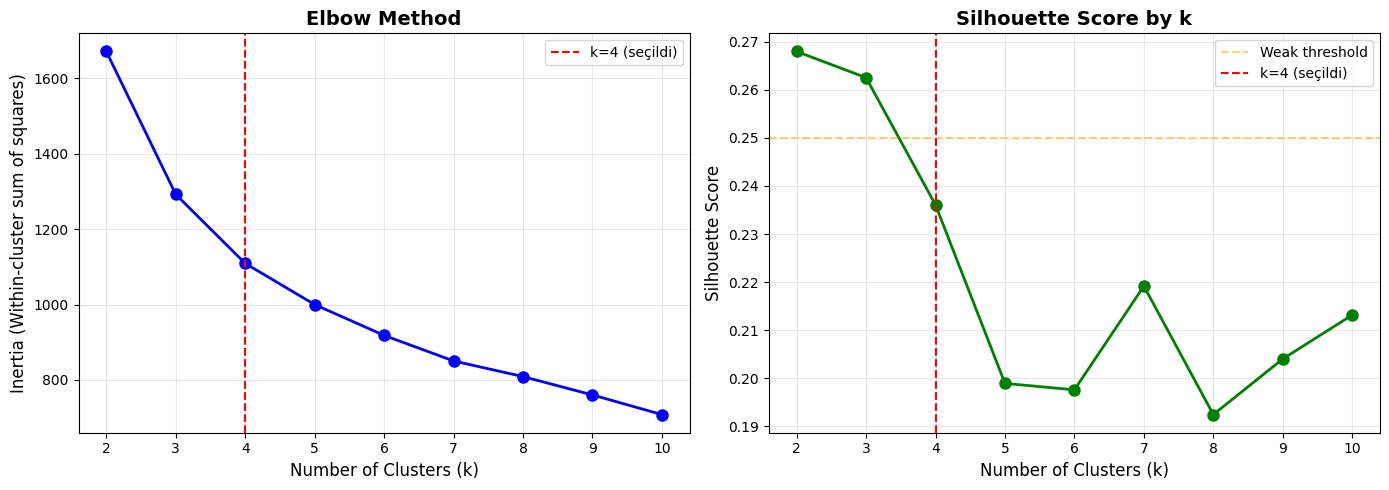


🎯 k=4 ile K-Means Clustering yapılıyor...

📊 Clustering Metrikleri:
   • Silhouette Score: 0.236
   • Davies-Bouldin Index: 1.334
     (Davies-Bouldin: düşük = iyi, yüksek = cluster'lar overlap)

📍 Cluster Dağılımı:
   Cluster 0: 60 havalimanı (25.4%)
   Cluster 1: 112 havalimanı (47.5%)
   Cluster 2: 24 havalimanı (10.2%)
   Cluster 3: 40 havalimanı (16.9%)


In [42]:
print("\n\n📈 ADIM 4: Elbow Grafiği ve Clustering\n")

# Elbow ve Silhouette grafiklerini çiz
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=4, color='red', linestyle='--', label='k=4 (seçildi)')
axes[0].legend()

# Silhouette plot
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score by k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0.25, color='orange', linestyle='--', alpha=0.5, label='Weak threshold')
axes[1].axvline(x=4, color='red', linestyle='--', label='k=4 (seçildi)')
axes[1].legend()

plt.tight_layout()
plt.savefig('../data/kpis/ml_airport_clustering_elbow.png', dpi=300, bbox_inches='tight')
print("✅ Grafik kaydedildi: ml_airport_clustering_elbow.png")
plt.show()

# k=4 ile final clustering
print("\n🎯 k=4 ile K-Means Clustering yapılıyor...")
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
df_airport_profile_filtered['Cluster'] = kmeans_final.fit_predict(X_scaled)

# Cluster metrikleri
print(f"\n📊 Clustering Metrikleri:")
print(f"   • Silhouette Score: {silhouette_score(X_scaled, df_airport_profile_filtered['Cluster']):.3f}")
print(f"   • Davies-Bouldin Index: {davies_bouldin_score(X_scaled, df_airport_profile_filtered['Cluster']):.3f}")
print(f"     (Davies-Bouldin: düşük = iyi, yüksek = cluster'lar overlap)")

# Her cluster'daki havalimanı sayısı
print(f"\n📍 Cluster Dağılımı:")
cluster_counts = df_airport_profile_filtered['Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    pct = count / len(df_airport_profile_filtered) * 100
    print(f"   Cluster {cluster_id}: {count} havalimanı ({pct:.1f}%)")

In [43]:
print("\n\n🔍 ADIM 5: CLUSTER PROFİLLERİ\n")
print("=" * 80)

# Her cluster için ortalama değerler
cluster_profiles = df_airport_profile_filtered.groupby('Cluster')[feature_cols].mean()

for cluster_id in range(optimal_k):
    print(f"\n{'='*80}")
    print(f"📍 CLUSTER {cluster_id}")
    print(f"{'='*80}")
    
    cluster_data = df_airport_profile_filtered[df_airport_profile_filtered['Cluster'] == cluster_id]
    
    print(f"\n📊 Cluster Özellikleri:")
    print(f"   • Havalimanı sayısı: {len(cluster_data)}")
    print(f"   • Ortalama kalkış gecikmesi: {cluster_profiles.loc[cluster_id, 'Avg_Dep_Delay']:.2f} dk")
    print(f"   • Ortalama varış gecikmesi: {cluster_profiles.loc[cluster_id, 'Avg_Arr_Delay']:.2f} dk")
    print(f"   • Gecikme oranı: {cluster_profiles.loc[cluster_id, 'Delay_Rate']:.1%}")
    print(f"   • İptal oranı: {cluster_profiles.loc[cluster_id, 'Cancellation_Rate']:.1%}")
    print(f"   • Ortalama taxi-out: {cluster_profiles.loc[cluster_id, 'Avg_Taxi_Out']:.1f} dk")
    print(f"   • Ortalama mesafe: {cluster_profiles.loc[cluster_id, 'Avg_Distance']:.0f} mil")
    print(f"   • Ortalama havayolu sayısı: {cluster_profiles.loc[cluster_id, 'Unique_Carriers']:.1f}")
    print(f"   • Ortalama destinasyon: {cluster_profiles.loc[cluster_id, 'Unique_Destinations']:.1f}")
    print(f"   • Peak saatlerde yoğunluk: {cluster_profiles.loc[cluster_id, 'Peak_Congestion_Rate']:.1%}")
    
    print(f"\n🏆 Top 5 Havalimanı:")
    top_airports = cluster_data.nlargest(5, 'Total_Flights')[['AIRPORT', 'Total_Flights', 'Unique_Destinations']]
    for idx, row in top_airports.iterrows():
        print(f"   • {row['AIRPORT']}: {row['Total_Flights']:,} uçuş, {row['Unique_Destinations']:.0f} destinasyon")

print("\n" + "=" * 80)



🔍 ADIM 5: CLUSTER PROFİLLERİ


📍 CLUSTER 0

📊 Cluster Özellikleri:
   • Havalimanı sayısı: 60
   • Ortalama kalkış gecikmesi: 8.85 dk
   • Ortalama varış gecikmesi: 4.24 dk
   • Gecikme oranı: 17.0%
   • İptal oranı: 1.5%
   • Ortalama taxi-out: 13.2 dk
   • Ortalama mesafe: 734 mil
   • Ortalama havayolu sayısı: 8.0
   • Ortalama destinasyon: 30.4
   • Peak saatlerde yoğunluk: 55.0%

🏆 Top 5 Havalimanı:
   • BWI: 480,087 uçuş, 67 destinasyon
   • MDW: 429,804 uçuş, 69 destinasyon
   • SAN: 401,602 uçuş, 51 destinasyon
   • TPA: 342,435 uçuş, 61 destinasyon
   • DAL: 319,267 uçuş, 51 destinasyon

📍 CLUSTER 1

📊 Cluster Özellikleri:
   • Havalimanı sayısı: 112
   • Ortalama kalkış gecikmesi: 9.45 dk
   • Ortalama varış gecikmesi: 6.41 dk
   • Gecikme oranı: 15.8%
   • İptal oranı: 2.8%
   • Ortalama taxi-out: 14.7 dk
   • Ortalama mesafe: 418 mil
   • Ortalama havayolu sayısı: 3.6
   • Ortalama destinasyon: 6.2
   • Peak saatlerde yoğunluk: 55.0%

🏆 Top 5 Havalimanı:
   • BUR: 114,022

In [44]:
print("\n\n🏷️ ADIM 6: CLUSTER İSİMLENDİRME\n")
print("=" * 80)

# Cluster'ları karakterize et
cluster_names = {}

for cluster_id in range(optimal_k):
    profile = cluster_profiles.loc[cluster_id]
    
    # Büyüklük
    avg_flights = df_airport_profile_filtered[
        df_airport_profile_filtered['Cluster'] == cluster_id
    ]['Total_Flights'].mean()
    
    avg_destinations = profile['Unique_Destinations']
    avg_delay = profile['Avg_Dep_Delay']
    delay_rate = profile['Delay_Rate']
    
    # İsimlendirme mantığı
    if avg_destinations > 80 and avg_flights > 500000:
        name = "🌟 Major Hub Airports"
        desc = "Büyük hub'lar - yüksek trafik, çok destinasyon, orta-yüksek gecikme"
    elif avg_destinations > 40 and avg_flights > 200000:
        name = "🏢 Regional Hub Airports"
        desc = "Orta büyüklük hub'lar - dengeli operasyon"
    elif delay_rate > 0.18:
        name = "⚠️ High-Delay Congested"
        desc = "Yüksek gecikme riski olan yoğun havalimanları"
    else:
        name = "✈️ Efficient Regional"
        desc = "Küçük-orta havalimanları - düşük gecikme, verimli"
    
    cluster_names[cluster_id] = {'name': name, 'description': desc}
    
    print(f"\nCluster {cluster_id}: {name}")
    print(f"   └─ {desc}")

# İsimleri dataframe'e ekle
df_airport_profile_filtered['Cluster_Name'] = df_airport_profile_filtered['Cluster'].map(
    lambda x: cluster_names[x]['name']
)

print("\n✅ Cluster'lar isimlendirildi!")



🏷️ ADIM 6: CLUSTER İSİMLENDİRME


Cluster 0: ✈️ Efficient Regional
   └─ Küçük-orta havalimanları - düşük gecikme, verimli

Cluster 1: ✈️ Efficient Regional
   └─ Küçük-orta havalimanları - düşük gecikme, verimli

Cluster 2: 🌟 Major Hub Airports
   └─ Büyük hub'lar - yüksek trafik, çok destinasyon, orta-yüksek gecikme

Cluster 3: ✈️ Efficient Regional
   └─ Küçük-orta havalimanları - düşük gecikme, verimli

✅ Cluster'lar isimlendirildi!




🔧 Cluster İsimlerini Düzeltme + PCA Görselleştirme

📋 Güncellenmiş Cluster Özeti:

🏢 Medium Regional Hubs
  ├─ Tanım: Orta büyüklük havalimanları - 30+ destinasyon, dengeli operasyon
  ├─ Örnek: BWI, MDW, SAN - Orta hub'lar
  └─ Havalimanı sayısı: 60

✈️ Small Regional Airports
  ├─ Tanım: Küçük bölgesel havalimanları - az destinasyon, düşük trafik
  ├─ Örnek: BUR, RIC, MSN - Lokal hizmet
  └─ Havalimanı sayısı: 112

🌟 Major Hub Airports
  ├─ Tanım: Mega hub'lar - 90+ destinasyon, yüksek trafik, orta gecikme
  ├─ Örnek: ATL, ORD, DFW, DEN - Network merkezi
  └─ Havalimanı sayısı: 24

🏝️ Efficient Tourist/Remote
  ├─ Tanım: Turist/uzak bölge havalimanları - düşük gecikme, özel karakteristik
  ├─ Örnek: HNL, OGG, ANC - Hawaii/Alaska havalimanları
  └─ Havalimanı sayısı: 40


📊 PCA ile 2D Görselleştirme yapılıyor...

📊 PCA Varyans Açıklaması:
   • PC1: 36.3%
   • PC2: 27.5%
   • Toplam: 63.8%


C:\Users\ysfcl\AppData\Local\Temp\ipykernel_33216\1991525118.py:113: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ysfcl\AppData\Local\Temp\ipykernel_33216\1991525118.py:113: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ysfcl\AppData\Local\Temp\ipykernel_33216\1991525118.py:113: UserWarning: Glyph 127965 (\N{DESERT ISLAND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ysfcl\AppData\Local\Temp\ipykernel_33216\1991525118.py:114: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  plt.savefig('../data/kpis/ml_airport_clustering_pca.png', dpi=300, bbox_inches='tight')
C:\Users\ysfcl\AppData\Local\Temp\ipykernel_33216\1991525118.py:114: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.savefig('../data/kpis/ml_airport_clustering_pca.png', dpi=300, bbox_inches='tight')
C:\Users\y


✅ PCA görselleştirmesi kaydedildi: ml_airport_clustering_pca.png


C:\Users\ysfcl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ysfcl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ysfcl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127965 (\N{DESERT ISLAND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


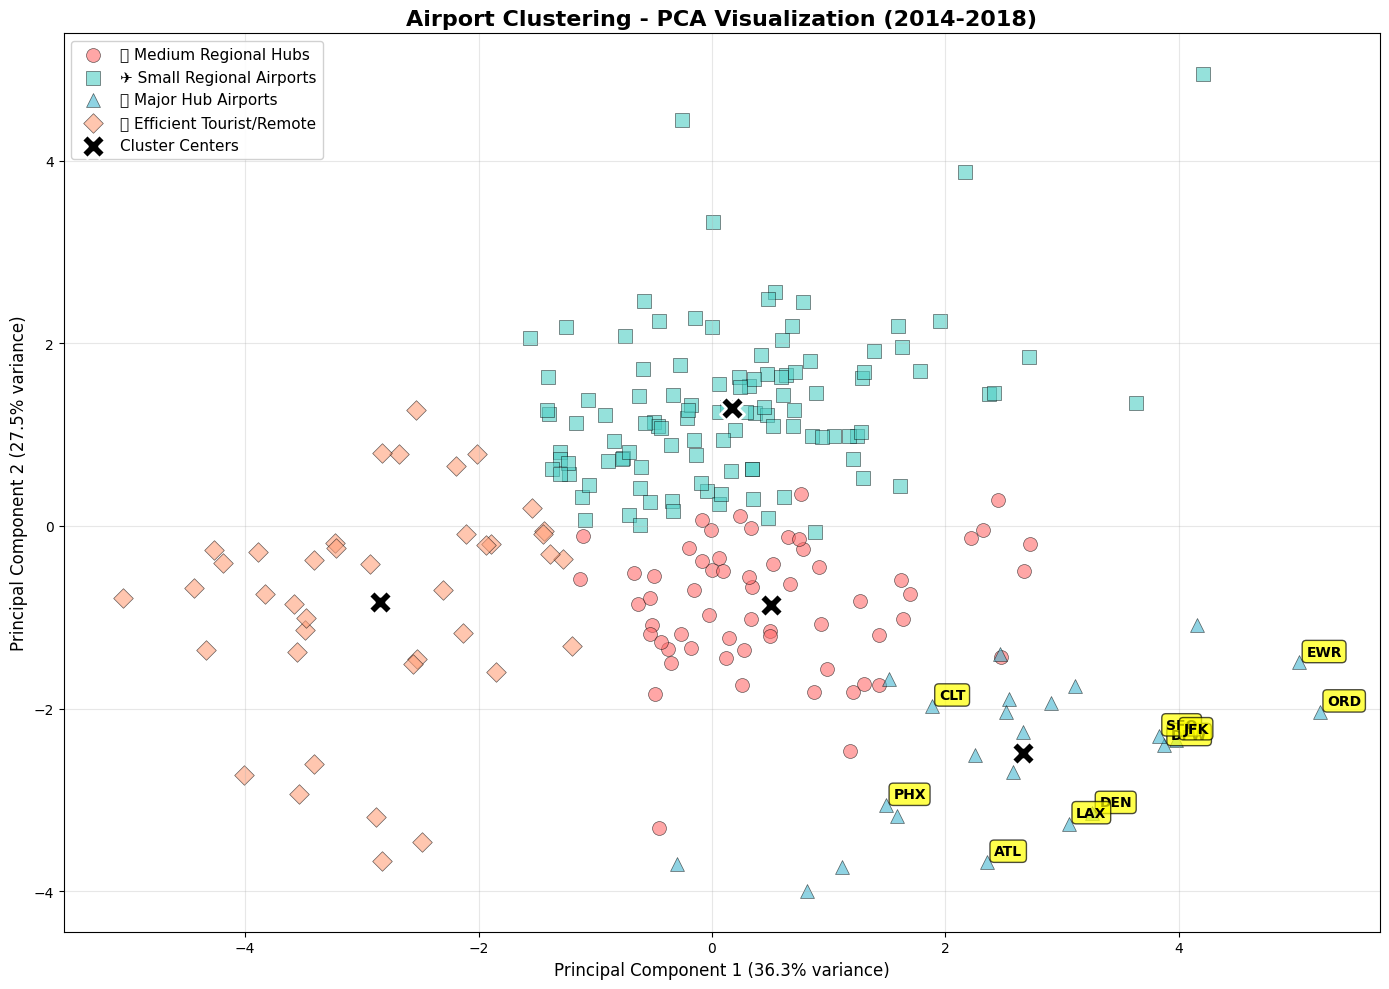

In [47]:
print("\n\n🔧 Cluster İsimlerini Düzeltme + PCA Görselleştirme\n")
print("=" * 80)

# Manuel isimlendirme - profillere bakarak
cluster_names_corrected = {
    0: {
        'name': '🏢 Medium Regional Hubs',
        'description': 'Orta büyüklük havalimanları - 30+ destinasyon, dengeli operasyon',
        'characteristics': 'BWI, MDW, SAN - Orta hub\'lar'
    },
    1: {
        'name': '✈️ Small Regional Airports',
        'description': 'Küçük bölgesel havalimanları - az destinasyon, düşük trafik',
        'characteristics': 'BUR, RIC, MSN - Lokal hizmet'
    },
    2: {
        'name': '🌟 Major Hub Airports',
        'description': 'Mega hub\'lar - 90+ destinasyon, yüksek trafik, orta gecikme',
        'characteristics': 'ATL, ORD, DFW, DEN - Network merkezi'
    },
    3: {
        'name': '🏝️ Efficient Tourist/Remote',
        'description': 'Turist/uzak bölge havalimanları - düşük gecikme, özel karakteristik',
        'characteristics': 'HNL, OGG, ANC - Hawaii/Alaska havalimanları'
    }
}

# DataFrame'e uygula
df_airport_profile_filtered['Cluster_Name'] = df_airport_profile_filtered['Cluster'].map(
    lambda x: cluster_names_corrected[x]['name']
)

# Özet göster
print("📋 Güncellenmiş Cluster Özeti:\n")
for cluster_id, info in cluster_names_corrected.items():
    count = len(df_airport_profile_filtered[df_airport_profile_filtered['Cluster'] == cluster_id])
    print(f"{info['name']}")
    print(f"  ├─ Tanım: {info['description']}")
    print(f"  ├─ Örnek: {info['characteristics']}")
    print(f"  └─ Havalimanı sayısı: {count}\n")

# PCA ile 9 boyutu 2 boyuta indirge
print("\n📊 PCA ile 2D Görselleştirme yapılıyor...\n")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"📊 PCA Varyans Açıklaması:")
print(f"   • PC1: {pca.explained_variance_ratio_[0]:.1%}")
print(f"   • PC2: {pca.explained_variance_ratio_[1]:.1%}")
print(f"   • Toplam: {pca.explained_variance_ratio_.sum():.1%}")

# Görselleştirme
fig, ax = plt.subplots(figsize=(14, 10))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
markers = ['o', 's', '^', 'D']

for cluster_id in range(optimal_k):
    mask = df_airport_profile_filtered['Cluster'].values == cluster_id
    cluster_points = X_pca[mask]
    
    ax.scatter(
        cluster_points[:, 0], 
        cluster_points[:, 1],
        c=colors[cluster_id],
        marker=markers[cluster_id],
        s=100,
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5,
        label=cluster_names_corrected[cluster_id]['name']
    )

# Major hub'ları işaretle
major_hubs = ['ATL', 'ORD', 'DFW', 'DEN', 'LAX', 'SFO', 'JFK', 'EWR', 'CLT', 'PHX']
df_with_pca = df_airport_profile_filtered.copy()
df_with_pca['PCA1'] = X_pca[:, 0]
df_with_pca['PCA2'] = X_pca[:, 1]

for airport in major_hubs:
    if airport in df_with_pca['AIRPORT'].values:
        airport_data = df_with_pca[df_with_pca['AIRPORT'] == airport].iloc[0]
        ax.annotate(
            airport,
            (airport_data['PCA1'], airport_data['PCA2']),
            fontsize=10,
            fontweight='bold',
            xytext=(5, 5),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7)
        )

# Cluster merkezlerini göster
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
ax.scatter(
    centroids_pca[:, 0], 
    centroids_pca[:, 1],
    c='black',
    marker='X',
    s=300,
    edgecolors='white',
    linewidth=2,
    label='Cluster Centers',
    zorder=5
)

ax.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title('Airport Clustering - PCA Visualization (2014-2018)', fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/kpis/ml_airport_clustering_pca.png', dpi=300, bbox_inches='tight')
print("\n✅ PCA görselleştirmesi kaydedildi: ml_airport_clustering_pca.png")
plt.show()



📊 ADIM 8: Cluster Karşılaştırma - Radar Chart



C:\Users\ysfcl\AppData\Local\Temp\ipykernel_33216\994611303.py:41: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ysfcl\AppData\Local\Temp\ipykernel_33216\994611303.py:41: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ysfcl\AppData\Local\Temp\ipykernel_33216\994611303.py:41: UserWarning: Glyph 127965 (\N{DESERT ISLAND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ysfcl\AppData\Local\Temp\ipykernel_33216\994611303.py:42: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  plt.savefig('../data/kpis/ml_airport_clustering_radar.png', dpi=300, bbox_inches='tight')
C:\Users\ysfcl\AppData\Local\Temp\ipykernel_33216\994611303.py:42: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  plt.savefig('../data/kpis/ml_airport_clustering_radar.png', dpi=300, bbox_inches='tight')
C:\Users\ysfcl\A

✅ Radar chart kaydedildi: ml_airport_clustering_radar.png


C:\Users\ysfcl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ysfcl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ysfcl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127965 (\N{DESERT ISLAND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


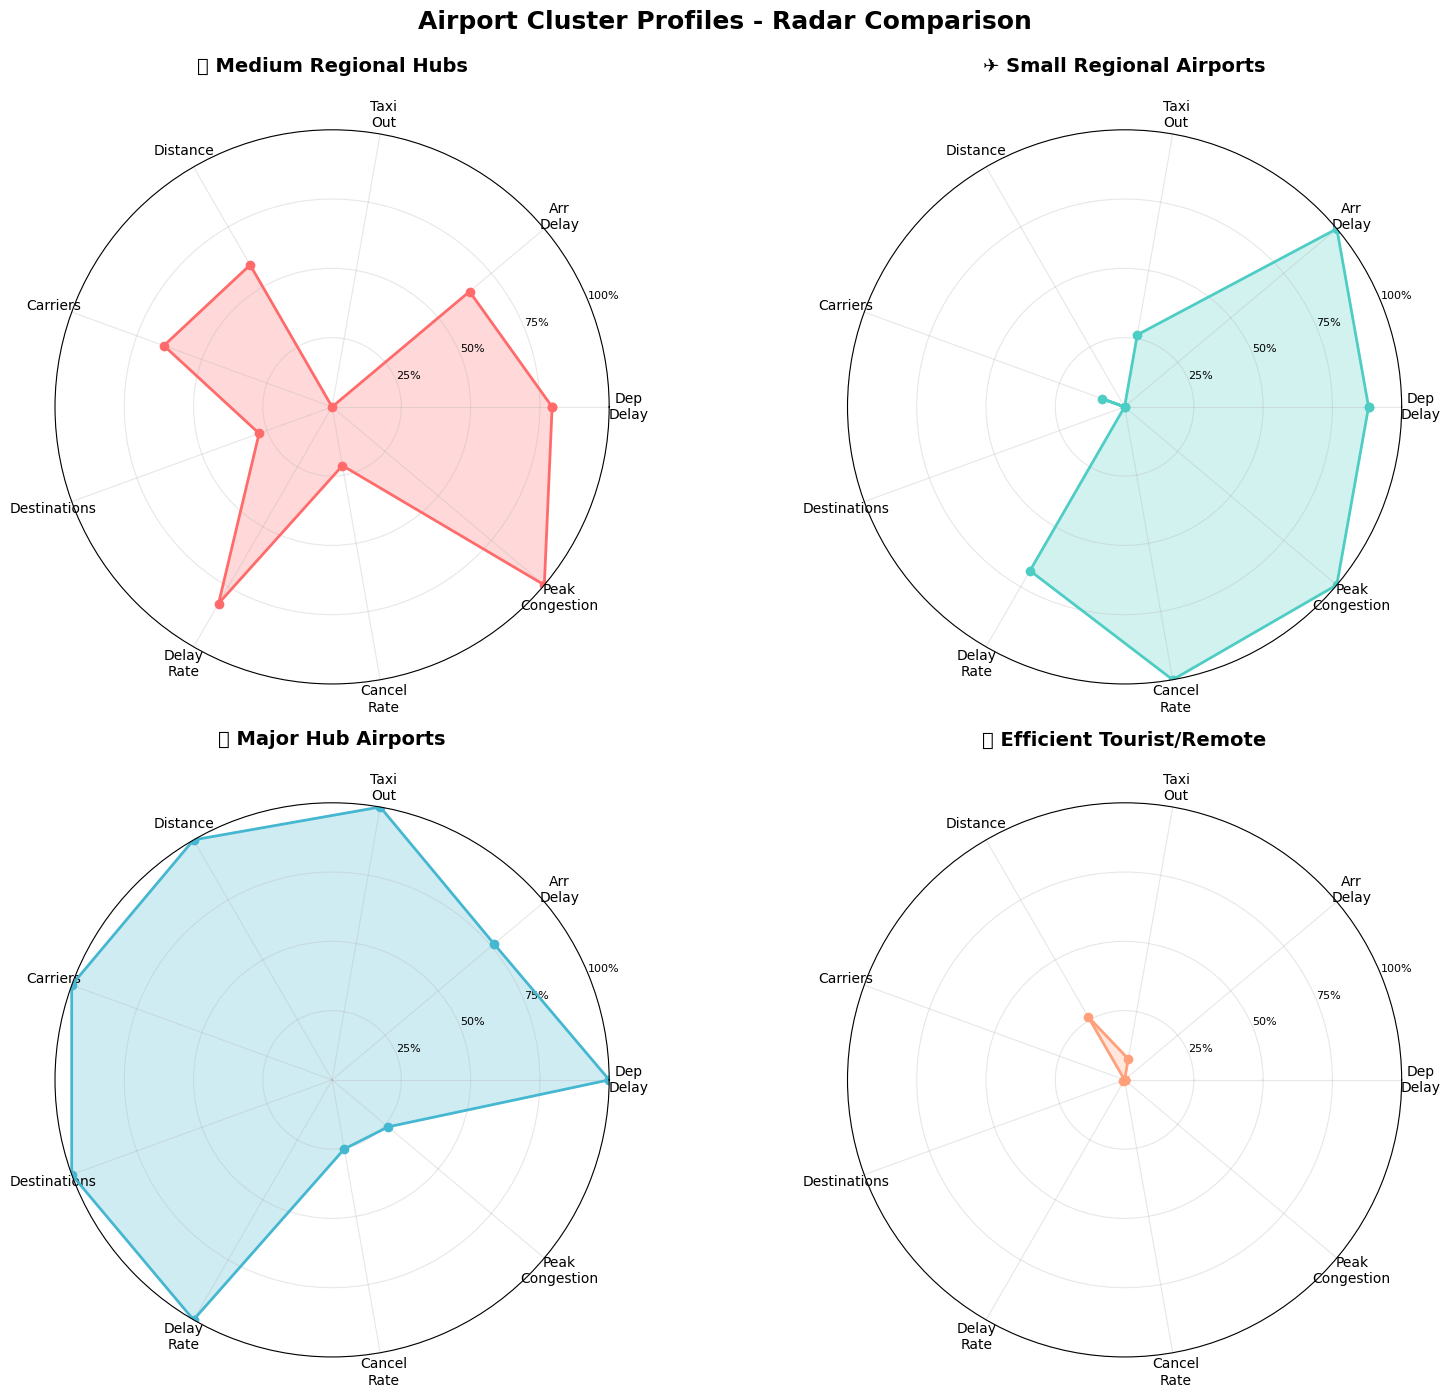

In [48]:
print("\n\n📊 ADIM 8: Cluster Karşılaştırma - Radar Chart\n")

# Her cluster için normalize edilmiş ortalamalar
cluster_profiles_normalized = cluster_profiles.copy()
for col in feature_cols:
    min_val = cluster_profiles[col].min()
    max_val = cluster_profiles[col].max()
    if max_val > min_val:  # Avoid division by zero
        cluster_profiles_normalized[col] = (cluster_profiles[col] - min_val) / (max_val - min_val)
    else:
        cluster_profiles_normalized[col] = 0

# Radar chart
fig, axes = plt.subplots(2, 2, figsize=(16, 14), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

# Feature isimleri kısalt
feature_labels = ['Dep\nDelay', 'Arr\nDelay', 'Taxi\nOut', 'Distance', 
                  'Carriers', 'Destinations', 'Delay\nRate', 'Cancel\nRate', 'Peak\nCongestion']

angles = np.linspace(0, 2 * np.pi, len(feature_cols), endpoint=False).tolist()
angles += angles[:1]  # Close the plot

for idx, cluster_id in enumerate(range(optimal_k)):
    ax = axes[idx]
    
    values = cluster_profiles_normalized.loc[cluster_id].tolist()
    values += values[:1]  # Close the plot
    
    ax.plot(angles, values, 'o-', linewidth=2, color=colors[cluster_id])
    ax.fill(angles, values, alpha=0.25, color=colors[cluster_id])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_labels, size=10)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(['25%', '50%', '75%', '100%'], size=8)
    ax.set_title(cluster_names_corrected[cluster_id]['name'], size=14, fontweight='bold', pad=20)
    ax.grid(True, alpha=0.3)

plt.suptitle('Airport Cluster Profiles - Radar Comparison', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../data/kpis/ml_airport_clustering_radar.png', dpi=300, bbox_inches='tight')
print("✅ Radar chart kaydedildi: ml_airport_clustering_radar.png")
plt.show()


In [49]:
print("\n\n💾 ADIM 9: Cluster Sonuçlarını CSV'ye Kaydetme\n")
print("=" * 80)

# 1. Havalimanı bazında cluster bilgisi
df_airport_clusters = df_airport_profile_filtered[[
    'AIRPORT', 'Cluster', 'Cluster_Name', 'Total_Flights', 
    'Avg_Dep_Delay', 'Avg_Arr_Delay', 'Delay_Rate', 'Cancellation_Rate',
    'Avg_Taxi_Out', 'Avg_Distance', 'Unique_Carriers', 'Unique_Destinations',
    'Peak_Congestion_Rate'
]].copy()

# Yuvarlama
numeric_cols = df_airport_clusters.select_dtypes(include=[np.number]).columns
df_airport_clusters[numeric_cols] = df_airport_clusters[numeric_cols].round(2)

# CSV'ye kaydet
output_path_airports = '../data/kpis/ml_airport_clusters.csv'
df_airport_clusters.to_csv(output_path_airports, index=False, encoding='utf-8')
print(f"✅ Havalimanı cluster'ları kaydedildi: {len(df_airport_clusters)} satır")
print(f"   → {output_path_airports}")

# 2. Cluster profilleri özet
cluster_summary = []
for cluster_id in range(optimal_k):
    summary = {
        'Cluster_ID': cluster_id,
        'Cluster_Name': cluster_names_corrected[cluster_id]['name'],
        'Description': cluster_names_corrected[cluster_id]['description'],
        'Airport_Count': len(df_airport_clusters[df_airport_clusters['Cluster'] == cluster_id]),
        'Avg_Dep_Delay': cluster_profiles.loc[cluster_id, 'Avg_Dep_Delay'],
        'Avg_Arr_Delay': cluster_profiles.loc[cluster_id, 'Avg_Arr_Delay'],
        'Avg_Delay_Rate': cluster_profiles.loc[cluster_id, 'Delay_Rate'],
        'Avg_Cancel_Rate': cluster_profiles.loc[cluster_id, 'Cancellation_Rate'],
        'Avg_Destinations': cluster_profiles.loc[cluster_id, 'Unique_Destinations'],
        'Avg_Carriers': cluster_profiles.loc[cluster_id, 'Unique_Carriers'],
        'Avg_Distance': cluster_profiles.loc[cluster_id, 'Avg_Distance'],
        'Avg_Taxi_Out': cluster_profiles.loc[cluster_id, 'Avg_Taxi_Out'],
        'Peak_Congestion': cluster_profiles.loc[cluster_id, 'Peak_Congestion_Rate']
    }
    cluster_summary.append(summary)

df_cluster_summary = pd.DataFrame(cluster_summary)
df_cluster_summary = df_cluster_summary.round(2)

output_path_summary = '../data/kpis/ml_airport_cluster_summary.csv'
df_cluster_summary.to_csv(output_path_summary, index=False, encoding='utf-8')
print(f"\n✅ Cluster özet profilleri kaydedildi: {len(df_cluster_summary)} satır")
print(f"   → {output_path_summary}")

# 3. Top havalimanları her cluster'dan
print("\n\n📋 Her Cluster'dan Top 5 Havalimanı:\n")
for cluster_id in range(optimal_k):
    print(f"\n{cluster_names_corrected[cluster_id]['name']}:")
    top_5 = df_airport_clusters[df_airport_clusters['Cluster'] == cluster_id].nlargest(5, 'Total_Flights')
    for idx, row in top_5.iterrows():
        print(f"   {row['AIRPORT']:4s} - {row['Total_Flights']:8,.0f} uçuş | "
              f"{row['Unique_Destinations']:3.0f} dest | "
              f"Delay: {row['Delay_Rate']:.1%}")

print("\n" + "=" * 80)
print("✅ SENARYO 5 TAMAMLANDI!")
print(f"   • 2 Görselleştirme PNG")
print(f"   • 2 CSV dosyası")
print(f"   • {len(df_airport_clusters)} havalimanı cluster'landı")
print("=" * 80)



💾 ADIM 9: Cluster Sonuçlarını CSV'ye Kaydetme

✅ Havalimanı cluster'ları kaydedildi: 236 satır
   → ../data/kpis/ml_airport_clusters.csv

✅ Cluster özet profilleri kaydedildi: 4 satır
   → ../data/kpis/ml_airport_cluster_summary.csv


📋 Her Cluster'dan Top 5 Havalimanı:


🏢 Medium Regional Hubs:
   BWI  -  480,087 uçuş |  67 dest | Delay: 21.0%
   MDW  -  429,804 uçuş |  69 dest | Delay: 24.0%
   SAN  -  401,602 uçuş |  51 dest | Delay: 17.0%
   TPA  -  342,435 uçuş |  61 dest | Delay: 18.0%
   DAL  -  319,267 uçuş |  51 dest | Delay: 24.0%

✈️ Small Regional Airports:
   BUR  -  114,022 uçuş |  12 dest | Delay: 17.0%
   RIC  -   86,976 uçuş |  17 dest | Delay: 18.0%
   MSN  -   49,295 uçuş |  17 dest | Delay: 14.0%
   SAV  -   46,937 uçuş |  14 dest | Delay: 18.0%
   FAT  -   45,459 uçuş |  10 dest | Delay: 16.0%

🌟 Major Hub Airports:
   ATL  - 1,869,505 uçuş | 167 dest | Delay: 17.0%
   ORD  - 1,407,200 uçuş | 162 dest | Delay: 22.0%
   DFW  - 1,172,440 uçuş | 146 dest | Delay: 20